# Предсказание задержки авиарейса.

## Предобработка данных

В качестве исходных данных возьмем датасет по ссылке https://www.kaggle.com/datasets/ulrikthygepedersen/airlines-delay, содержащий в себе информацию о рейсе авиаперелета и факт о том, был ли рейс задержан или нет. При помощи различных классификаторов построим модели, которые будут предсказывать будет ли рейс задержан или нет. Затем выберем лучшие из получившихся моделей и попробуем улучшить качество за счет их смешивания. 

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('airlines_delay.csv')

In [3]:
df.head(10)

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0
5,3692.0,580.0,60.0,WN,MSY,BHM,4,0
6,1135.0,690.0,239.0,CO,EWR,DFW,4,0
7,1300.0,1210.0,80.0,AA,DFW,MEM,3,0
8,587.0,1295.0,105.0,FL,BWI,GRR,7,0
9,764.0,530.0,108.0,FL,ATL,PBI,3,0


**Значения признаков:**

*Flight* - номер рейса

*Time* - время вылета (номер минуты в сутках)

*Length* - время перелета

*Airline* - авиакомпания

*AirportFrom* - аэропорт, из которого происходит вылет

*AirportTo* - аэропорт, в который происходит прилет

*DayOfWeek* - номер дня недели (начиная с понедельника)

*Class* - была ли задержка (1 - да, 0 - нет)

In [4]:
df.shape

(539382, 8)

Проверим наличие дубликатов.

In [5]:
duplicateRows = df[df.duplicated()]
len(duplicateRows)

216618

Как можно заметить в данной выборке очень много полностью совпадающих строк. Возможно это по причине того, что для рейсов было составлено определенное расписание, предусматривающее повторяемость по времени вылета и дню недели, а также это возможно по причине внесения в датасет данной информации по ошибке. В данном случае мы этого точно знать не можем, поэтому необходимо удалить дубликаты.

In [6]:
df = df.drop_duplicates ()

Теперь проверим наличие пропусков.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322764 entries, 0 to 539379
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Flight       322764 non-null  float64
 1   Time         322764 non-null  float64
 2   Length       322764 non-null  float64
 3   Airline      322764 non-null  object 
 4   AirportFrom  322764 non-null  object 
 5   AirportTo    322764 non-null  object 
 6   DayOfWeek    322764 non-null  int64  
 7   Class        322764 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 22.2+ MB


In [8]:
df.shape

(322764, 8)

Делаем вывод о том, что в нашем датасете отсутствуют пропуски, а также, что после удаления такого большого количества дубликатов у нас всё равно осталась довольно большая выборка (вполне достаточная для обучения модели).

In [9]:
len(df[df['Class'] == 1])/df.shape[0]

0.4789939398445923

In [10]:
import matplotlib.pyplot as plt

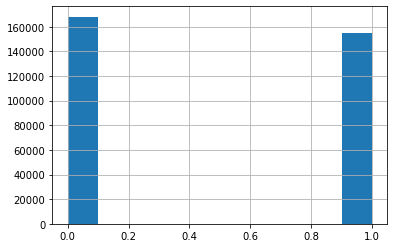

In [11]:
df['Class'].hist()
plt.show()

Имеем дело с хорошо сбалансированной выборкой, т.к. у нас приблизительно половина всех объектов принадлежат одному классу, а другая половина другому.

In [12]:
df['Flight'].unique()

array([2313., 6948., 1247., ..., 3207., 4710., 3518.])

In [13]:
len(df['Flight'].unique())

6585

Колонка Flight обозначает номер рейса и должна иметь дискретные значения. В нашем случае эта переменная имеет тип данных Float. Нам необходимо преобразовать их для начала в целые числа. Будет ли данный признак влиять положительным образом на результат решения задачи классификации или будет мешать, пока неизвестно. Проверим оба возможных варианта.

In [14]:
df = df.astype({'Flight': int})

Выберем способ кодирования категориальных признаков.

In [15]:
len(df['Airline'].unique())

18

In [16]:
len(df['AirportFrom'].unique())

293

In [17]:
len(df['AirportTo'].unique())

293

Как можно заметить, мы имеем довольно большое количество значений категориальных признаков. При использовании one-hot кодировании в этом случае возникнет большое количество новых признаков, что может усложнить нашу модель. В связи с этим будем использовать LabelEncoder.

In [18]:
from sklearn.preprocessing import LabelEncoder
columns = ['Airline', 'AirportFrom', 'AirportTo']
le = LabelEncoder()
df[columns] = df[columns].apply(lambda col: le.fit_transform(col))

In [19]:
df.head(5)

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313,1296.0,141.0,5,16,129,1,0
1,6948,360.0,146.0,12,65,208,4,0
2,1247,1170.0,143.0,3,35,60,3,0
3,31,1410.0,344.0,14,203,217,6,0
4,563,692.0,98.0,8,32,16,4,0


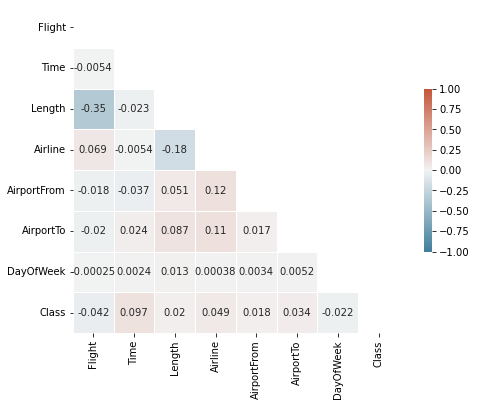

In [20]:
import seaborn as sns
import numpy as np

corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(9, 6))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           )
plt.show()

По матрице корреляции можно сказать, что признаки являются линейно независимыми, что сильно упрощает нам задачу. Однако, при этом можно заметить, что сами признаки также довольно слабо коррелируют с целевой переменной, что говорит нам о том, что скорее всего придется создавать какие-либо новые признаки на основе старых. Для начала попробуем несколько алгоритмов классификации по исходным данным и убедимся в том, что они не позволят нам создать качественную модель, затем попробуем сгенерировать новые признаки и посмотрим, к чего это приведет.

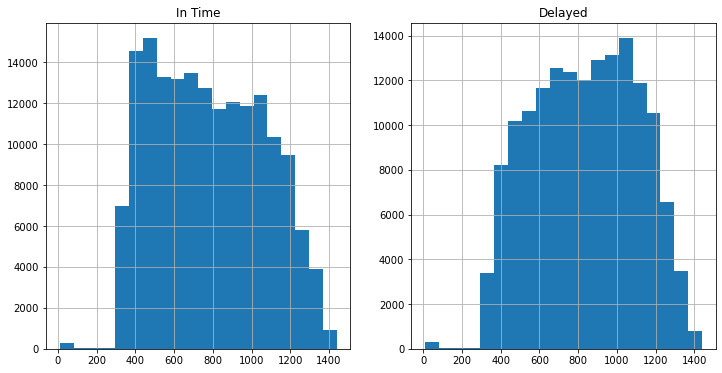

In [21]:
fig, axs = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)

axs[0].hist(df[df['Class'] == 0]['Time'], bins = 20)
axs[0].set_title('In Time')
axs[0].grid()
axs[1].hist(df[df['Class'] == 1]['Time'], bins = 20)
axs[1].grid()
axs[1].set_title('Delayed');

По данным гистограммам можно заметить, что рейсы попадающие в интервал от 900 до 1300 задерживаются чаще, чем остальные. Возможно, для улучшения качества модели нужно будет добавить бинарный признак, определяющий попадает ли рейс в данный интервал (значение 1) или нет (значение 0).

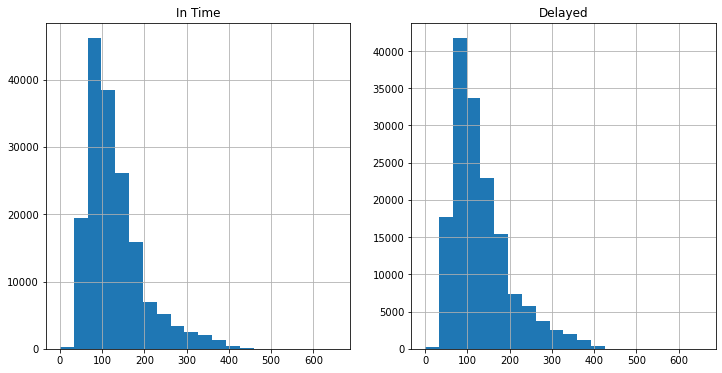

In [22]:
fig, axs = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)

axs[0].hist(df[df['Class'] == 0]['Length'], bins = 20)
axs[0].set_title('In Time')
axs[0].grid()
axs[1].hist(df[df['Class'] == 1]['Length'], bins = 20)
axs[1].grid()
axs[1].set_title('Delayed');

По данным гистограммам можно предположить, что при определенном фиксированном значении времени перелета вероятность задержки будет приблизительно 50 на 50. В данном случае не наблюдается явной картины, по которой можно было бы сказать, что например рейсы с более длинным временем перелета задерживаются чаще или наоборот.

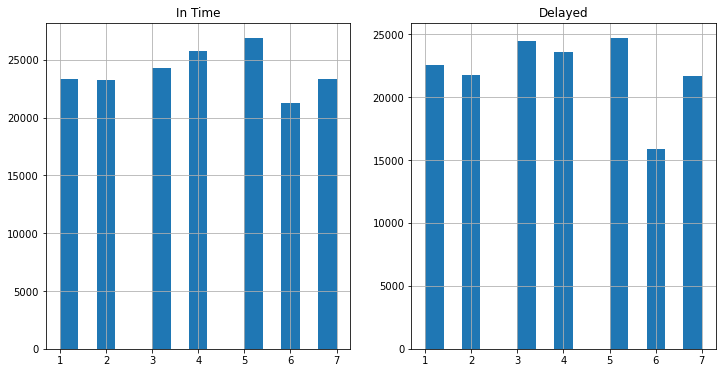

In [23]:
fig, axs = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)

axs[0].hist(df[df['Class'] == 0]['DayOfWeek'], bins = 15)
axs[0].set_title('In Time')
axs[0].grid()
axs[1].hist(df[df['Class'] == 1]['DayOfWeek'], bins = 15)
axs[1].grid()
axs[1].set_title('Delayed');

По данным гистограммам можно заметить, что во все дни недели соотношение задержанных и незадержанных рейсов приблизительно одинаковое. Также мы видим, что в выходные дни само количество перелетов меньше (дни №6 и №7). При этом в субботу соотношение задержанных и незадержанных рейсов немного меньше, чем в остальные дни.

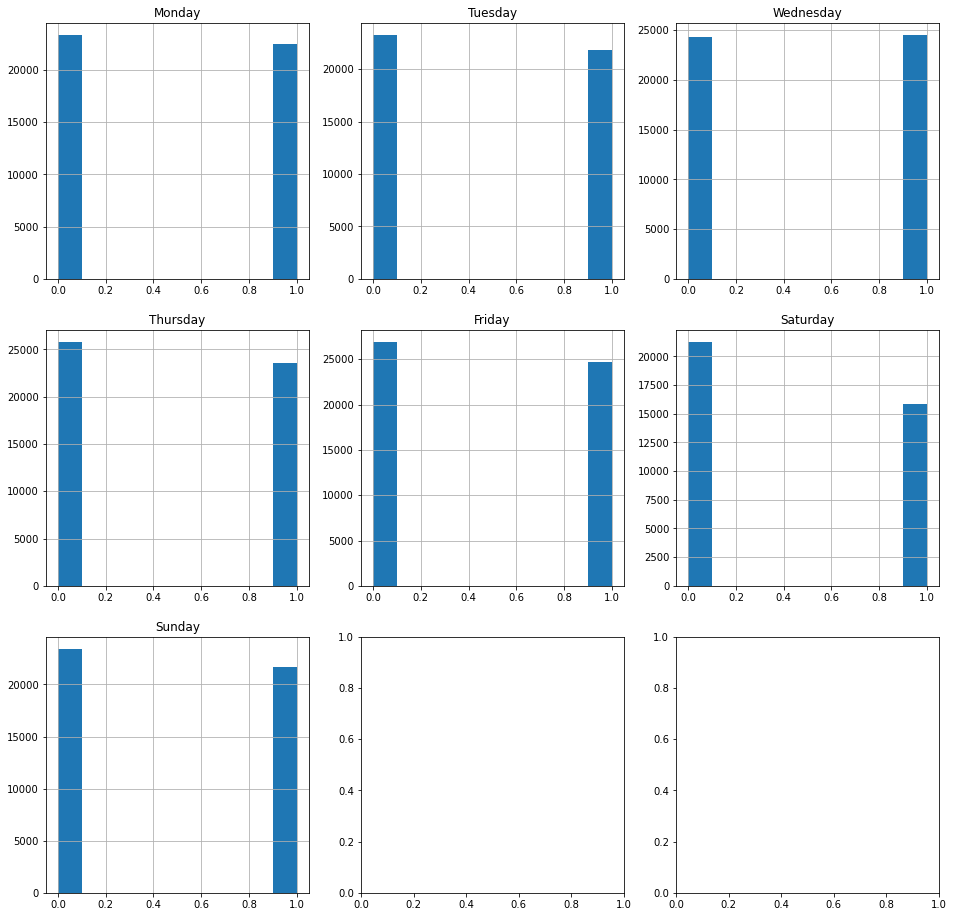

In [24]:
plots = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0]]

fig, axs = plt.subplots(figsize=(16, 16), ncols=3, nrows=3)
titles = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i in range(len(titles)):
    axs[plots[i][0], plots[i][1]].hist(df[df['DayOfWeek'] == i+1]['Class'], bins = 10)
    axs[plots[i][0], plots[i][1]].grid()
    axs[plots[i][0], plots[i][1]].set_title(titles[i])

Как можно заметить во все дни недели кроме субботы соотношение между задержанными рейсами и незадержанными приблизительно одинаковое. Учитывая, что в выходные дни количество само количество рейсов меньше, возможно для улучшения качества модели нужно будет ввести новый бинарный признак, который будет говорить о том, является ли день недели выходным (значение 1) или нет (значение 0). 

Однако, на данном этапе мы пока не можем с уверенностью утверждать о том, нужно ли вообще создавать новые признаки, т.к. мы не знаем какое качество модели нам дадут те признаки, которые у нас уже имеются. В связи с этим для начала мы построим модель по имеющимся признакам, проанализируем её качество, а затем поэкспериментируем с добавлением новых признаков и посмотрим, как это повлияет на качество модели.

In [25]:
X = df.drop('Class', axis = 1)
y = df['Class']

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [27]:
from sklearn.preprocessing import StandardScaler

object = StandardScaler() 
X_train.iloc[:, [1, 2]] = object.fit_transform(X_train.iloc[:, [1, 2]])

X_test.iloc[:, [1, 2]] = object.transform(X_test.iloc[:, [1, 2]])

## Построение моделей классификации

#### Алгоритм KNN (k ближайших соседей)

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from tqdm import tqdm

Алгоритм KNN довольно долгий, поэтому для него будем перебирать по сетке только 1 гиперпараметр для более быстрых вычслений.

In [196]:
k_range = list(range(1, 21))
knn = KNeighborsClassifier()

param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=5, scoring='f1', return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20]},
             return_train_score=True, scoring='f1')

In [197]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.4746171017985823
{'n_neighbors': 13}
KNeighborsClassifier(n_neighbors=13)


In [32]:
knn = KNeighborsClassifier(n_neighbors = 13)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [33]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.52
precision = 0.44
recall = 0.5
roc_auc = 0.52
f1 = 0.47


Получили неудовлетворительное качество модели.

#### Логистическая регрессия

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [182]:
lr = LogisticRegression()
C = range(1,20)
penalties = ['l2', 'l1', 'elasticnet', None]


param_grid = dict(penalty = penalties, C=C)
grid = GridSearchCV(lr, param_grid, cv=5, scoring='f1', return_train_score=True)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': range(1, 20),
                         'penalty': ['l2', 'l1', 'elasticnet', None]},
             return_train_score=True, scoring='f1')

In [183]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.4898776180562189
{'C': 4, 'penalty': 'l2'}
LogisticRegression(C=4)


In [36]:
lr = LogisticRegression(C = 4, penalty = 'l2')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [37]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.55
precision = 0.44
recall = 0.54
roc_auc = 0.55
f1 = 0.48


Получили неудовлетворительное качество модели.

#### Алгоритм SGD (Стохастический градиентный спуск)

In [31]:
from sklearn.linear_model import SGDClassifier

In [201]:
sgd = SGDClassifier()

losses = ["hinge", "modified_huber", "log"]
penalties = ['l2', 'l1', 'elasticnet', None]

sgd = SGDClassifier()
param_grid = dict(loss=losses, penalty = penalties)

grid = GridSearchCV(sgd, param_grid, cv=5, scoring='f1', return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid={'loss': ['hinge', 'modified_huber', 'log'],
                         'penalty': ['l2', 'l1', 'elasticnet', None]},
             return_train_score=True, scoring='f1')

In [202]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.46726550480492623
{'loss': 'hinge', 'penalty': None}
SGDClassifier(penalty=None)


In [39]:
sgd = SGDClassifier(loss = 'hinge', penalty = None)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

In [40]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.48
precision = 0.98
recall = 0.48
roc_auc = 0.53
f1 = 0.64


Качество модели стало лучше, но при этом доля правильных ответов по-прежнему низкая.

#### Алгоритм SVC (Метод опорных веторов).

In [32]:
from sklearn.svm import LinearSVC

SVC довольно долгий алгоритм, особенно в случае подбора гиперпараметров по сетке. Для начала проверим качество модели с гиперпараметрами по умолчанию. Если будет замечен прирост качества, то попробуем сделать подбор по сетке.

In [217]:
svc = LinearSVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [218]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.52
precision = 0.0
recall = 0.76
roc_auc = 0.64
f1 = 0.0


Алгоритм SVC показал с параметрами по умолчанию показал плохие результаты, т.к. метрика precision = 0 и как следствие f1 = 0. Попробуем для примера задать какое-нибудь значение гиперпараметра C.

In [219]:
svc = LinearSVC(C=10)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [220]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.48
precision = 1.0
recall = 0.48
roc_auc = 0.53
f1 = 0.65


Получили заметный прирост метрики precision. Попробуем подобрать гиперпараметр C по сетке для увеличения доли правильных ответов.

In [236]:
svc = LinearSVC()
C = range(1,50)

param_grid = dict(C=C)
grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(), param_grid={'C': range(1, 50)},
             return_train_score=True, scoring='accuracy')

In [237]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.5159117453393348
{'C': 9}
LinearSVC(C=9)


In [42]:
svc = LinearSVC(C=9)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [43]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.52
precision = 0.0
recall = 0.66
roc_auc = 0.59
f1 = 0.0


Получили также неудовлетворительное качество модели. Об этом говорит крайне низкое значение метрик precision и f1. Доля правильных ответов стала чуть больше, но при этом метрика precision = 0, что не может устраивать.

#### Наивный Байесовский классификатор

In [33]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [46]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print("Accuracy is: ", np.mean(y_test==y_pred))
print("CV accuracies are: ", cross_val_score(gnb, X_train, y_train, cv=5))

Accuracy is:  0.5569658163792213
CV accuracies are:  [0.55522606 0.5600062  0.55500476 0.55363268 0.55654406]


In [47]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.56
precision = 0.46
recall = 0.54
roc_auc = 0.55
f1 = 0.5


Получили неудовлетворительное качество модели.

#### Решающее дерево

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [231]:
dt = DecisionTreeClassifier(random_state = 20)
max_depths = [i for i in range(1,7)]
min_samples_leafs = [i for i in range(1, 30)]

param_grid = dict(max_depth=max_depths, min_samples_leaf = min_samples_leafs)
grid = GridSearchCV(dt, param_grid, cv=5, scoring='f1', return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=20),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             return_train_score=True, scoring='f1')

In [232]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.503285725643168
{'max_depth': 6, 'min_samples_leaf': 1}
DecisionTreeClassifier(max_depth=6, random_state=20)


In [49]:
dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 1, random_state = 20)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [50]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.59
precision = 0.43
recall = 0.6
roc_auc = 0.59
f1 = 0.5


Из всех элементарных классификаторов, которые мы опробовали выше самым оптимальным является решающее дерево, однако, даже его качество нас всё же не устраивает. Попробуем построить более мощные модели, такие как бэггинг и случайный лес. Если их качество нас также не устроит, то это будет говорить о том, что необходимо вернуться на первый шаг и осуществить определенную обработку исходного датасета (возможно, сгенерировать новые признаки на основе старых или убрать какие-то из имеющихся и т.п.). 
Средние значения метрик f1 по кросс-валидации по 5 фолдам на тренировочной выборке и значения, получившиеся на тестовой выборке отличаются незначительно. Отсюда возможно предположить, что даже несмотря на большой размер выборки возмодно наша модель недообучается. В случае переобучения наблюдалась бы заметная разница величин метрик для тренировочной и тестовой выборок. Также по матрице корреляции мы видели, что признаки слабо коррелируют с целевой переменной. Это может быть связано с тем, что факт задержки рейса может иметь и вероятностный характер. Сама задержка может быть связана с тех. обслуживанием самолета или с погодными условиями, тем не менее само качество модели нужно улучшить.

#### Бэггинг

In [35]:
from sklearn.ensemble import BaggingClassifier

In [268]:
dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 1, random_state = 20)
bagging = BaggingClassifier(base_estimator = dt, n_estimators = 50, random_state = 20)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)

In [269]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.59
precision = 0.41
recall = 0.61
roc_auc = 0.6
f1 = 0.49


Подберем гиперпараметр n_estimators по сетке.

In [272]:
dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 1, random_state = 20)
bagging = BaggingClassifier(base_estimator = dt, n_jobs = 4, n_estimators = 50, random_state = 20)

param_grid = [
    {
        'n_estimators':[i for i in range(1, 100)],
    }]

grid = GridSearchCV(bagging, param_grid, n_jobs = 4, cv=5, scoring='f1', return_train_score=True)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                                               random_state=20),
                                         n_estimators=50, n_jobs=4,
                                         random_state=20),
             n_jobs=4,
             param_grid=[{'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14, 15, 16, 17, 18, 19, 20,
                                           21, 22, 23, 24, 25, 26, 27, 28, 29,
                                           30, ...]}],
             return_train_score=True, scoring='f1')

In [273]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.4984634042051666
{'n_estimators': 1}
BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                        random_state=20),
                  n_estimators=1, n_jobs=4, random_state=20)


In [52]:
dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 1, random_state = 20)
bagging = BaggingClassifier(base_estimator = dt, n_estimators = 1, random_state = 20)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)

In [53]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.59
precision = 0.38
recall = 0.61
roc_auc = 0.59
f1 = 0.47


Получили неудовлетворительное качество модели, судя по метрикам.

#### Случайный лес

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [276]:
rf = RandomForestClassifier(n_estimators = 50, n_jobs = 4, random_state = 20)

param_grid = [
    {
        'max_depth':[i for i in range(1, 7)],
        'min_samples_split': [i for i in range(1,51)]
    }]

grid = GridSearchCV(rf, param_grid, n_jobs = 4, cv=5, scoring='f1', return_train_score=True)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=4,
                                              random_state=20),
             n_jobs=4,
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6],
                          'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                11, 12, 13, 14, 15, 16, 17, 18,
                                                19, 20, 21, 22, 23, 24, 25, 26,
                                                27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='f1')

In [277]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.4331235258303476
{'max_depth': 6, 'min_samples_split': 19}
RandomForestClassifier(max_depth=6, min_samples_split=19, n_estimators=50,
                       n_jobs=4, random_state=20)


In [55]:
rf = RandomForestClassifier(n_estimators = 50, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [56]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.59
precision = 0.34
recall = 0.63
roc_auc = 0.6
f1 = 0.44


In [280]:
rf = RandomForestClassifier(n_estimators = 50, n_jobs = 4, max_depth = 6 , min_samples_split = 19, random_state = 20)

param_grid = [
    {
        'n_estimators':[i for i in range(1, 100)],
    }]

grid = GridSearchCV(rf, param_grid, n_jobs = 4, cv=5, scoring='roc_auc', return_train_score=True)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=6, min_samples_split=19,
                                              n_estimators=50, n_jobs=4,
                                              random_state=20),
             n_jobs=4,
             param_grid=[{'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14, 15, 16, 17, 18, 19, 20,
                                           21, 22, 23, 24, 25, 26, 27, 28, 29,
                                           30, ...]}],
             return_train_score=True, scoring='roc_auc')

In [281]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.6243582583892284
{'n_estimators': 54}
RandomForestClassifier(max_depth=6, min_samples_split=19, n_estimators=54,
                       n_jobs=4, random_state=20)


In [57]:
rf = RandomForestClassifier(n_estimators = 54, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [58]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.59
precision = 0.34
recall = 0.63
roc_auc = 0.6
f1 = 0.44


Проверим метрики на тренировочной выборке.

In [59]:
y_pred = rf.predict(X_train)

accuracy = accuracy_score(y_pred, y_train)
precision = precision_score(y_pred, y_train)
recall = recall_score(y_pred, y_train)
roc_auc = roc_auc_score(y_pred, y_train)
f1 = f1_score(y_pred, y_train)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.59
precision = 0.34
recall = 0.63
roc_auc = 0.6
f1 = 0.44


Можно заметить, что значения метрик для тренировочной и тестовой выборок совпадают. Возможно, наша модель действительно недообучается из-за малого количества признаков и их слабой корреляции с целевой переменной.

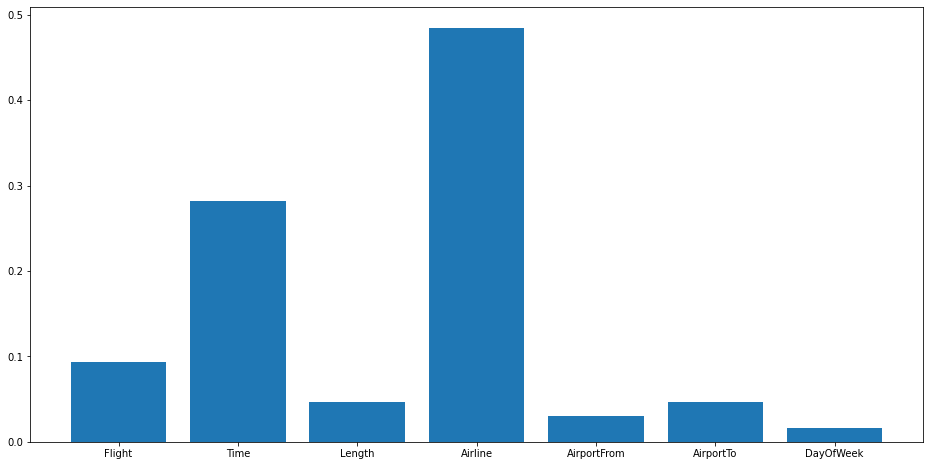

In [60]:
plt.figure(figsize = (16, 8))
plt.bar(X.columns, rf.feature_importances_);

Наибольшее влияние на факт задержки рейса оказывает признак "Airline" (авиакомпания) и "Time" (время вылета). Также определенное влияние имеет признак "Flight", но с ним мы поработаем позже при необходимости.

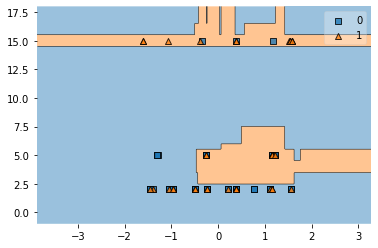

In [61]:
from mlxtend.plotting import plot_decision_regions

value = 20
width = 40

plot_decision_regions(X_test.values, y_test.values, rf, feature_index=[1,3], filler_feature_values={0: value, 2:value, 4: value, 5: value, 6: value}, 
                      filler_feature_ranges={0: width, 2: width, 4: width, 5: width, 6: width})

plt.show()

Можно заметить, объекты с одинаковыми значениями признаков могут иметь как класс "1", так и "0". В связи с этим идеального разбиения при любом алгоритме достичь довольно проблематично. Попробуем последовательно сгенерировать новые признаки и посмотрим, как это отразиться на качестве модели.

**Идеи для новых признаков:**

- проанализировать какие авиакомпании задерживают рейсы чаще всего, а какие реже и в зависимости от этого показателя разбить авиакомпании на группы. Т.е. получится своего рода "рейтинг" авиакомпаний;

- возможно аналогичным образом составить "рейтинг" рейсов;

- разбить время в сутках на интервалы, и создать новую переменную, указывающую на принадлежность времени вылета к определенному временному интервалу;

- создать переменную, указывающую на то, является ли день перелета выходным или нет;

- по переменным "AirportFrom" и "AirportTo" выделить все маршруты, и проанализировать какие из них чаще всего задерживаются, и по этому критерию составить "рейтинг" маршрутов.

Данные этапы будем выполнять поочередно и анализировать качество модели на примере алгоритмов RandomForest, SVC и SGD, так как они при определенных наборах гиперпараметров показали наиболее оптимальные результаты.

Также возможно после преобразования исходного датасета придется заново выполнять подбор гиперпараметров по сетке. Будем отталкиваться от ситуации.

In [37]:
df['Airline'].unique()

array([ 5, 12,  3, 14,  8, 15,  4,  1, 17,  6, 16,  0, 11, 13, 10,  2,  7,
        9])

In [38]:
delayed_part = {}

for i in df['Airline'].unique():
    delayed_part[i] = df[df['Airline'] == i]['Class'].mean()
    
parts = np.array(list(delayed_part.values()))
print(parts)

[0.47131086 0.47240606 0.48488427 0.41487576 0.36284373 0.66270715
 0.54293969 0.46094412 0.34132543 0.43903841 0.41496112 0.43803787
 0.34609738 0.37113025 0.43631501 0.4010942  0.47668568 0.44128275]


In [39]:
#Авиакомпаний не так много по количеству, поэтому попробуем их разбить на 4 группы нашего "рейтинга". 
#Для этого нужно 3 пороговых значения

delta = (np.max(parts) - np.min(parts)) / 4
A = np.min(parts) + delta
B = np.min(parts) + 2 * delta
C = np.min(parts) + 3 * delta

print(f'min_delay = {np.min(parts)}\nmax_delay = {np.max(parts)}\nA = {A}\nB = {B}\nC = {C}')

min_delay = 0.34132543103448276
max_delay = 0.662707149318178
A = 0.4216708606054066
B = 0.5020162901763303
C = 0.5823617197472541


In [40]:
delayed_part

{5: 0.4713108576596493,
 12: 0.4724060556139404,
 3: 0.4848842701936703,
 14: 0.4148757555406313,
 8: 0.36284372904091217,
 15: 0.662707149318178,
 4: 0.5429396894185626,
 1: 0.4609441151566469,
 17: 0.34132543103448276,
 6: 0.4390384112882153,
 16: 0.41496111826725823,
 0: 0.4380378657487091,
 11: 0.3460973819427453,
 13: 0.3711302531975985,
 10: 0.43631500742942053,
 2: 0.4010942041374594,
 7: 0.4766856759476686,
 9: 0.44128274616079494}

In [41]:
delayed_rating = {'A' : [], 'B' : [], 'C' : [], 'D' : []}
for i in delayed_part:
    if delayed_part[i] < A:
        delayed_rating['A'].append(i)
    elif (delayed_part[i] >= A) and (delayed_part[i] < B):
        delayed_rating['B'].append(i)
    elif (delayed_part[i] >= B) and (delayed_part[i] < C):
        delayed_rating['C'].append(i)
    else:
        delayed_rating['D'].append(i)      
        
print(delayed_rating)

{'A': [14, 8, 17, 16, 11, 13, 2], 'B': [5, 12, 3, 1, 6, 0, 10, 7, 9], 'C': [4], 'D': [15]}


In [42]:
df_1 = df.copy()

# создадим колонки соответствующие рейтингу по принципу One-Hot кодирования

df_1['AirlineRating_A'] = np.where(df_1['Airline'].isin(delayed_rating['A']), 1, 0)
df_1['AirlineRating_B'] = np.where(df_1['Airline'].isin(delayed_rating['B']), 1, 0)
df_1['AirlineRating_C'] = np.where(df_1['Airline'].isin(delayed_rating['C']), 1, 0)
df_1['AirlineRating_D'] = np.where(df_1['Airline'].isin(delayed_rating['D']), 1, 0)

In [43]:
print(df_1[df_1['AirlineRating_A'] == 1]['Airline'].unique() == delayed_rating['A'],
      df_1[df_1['AirlineRating_B'] == 1]['Airline'].unique() == delayed_rating['B'],
      df_1[df_1['AirlineRating_C'] == 1]['Airline'].unique() == delayed_rating['C'],
      df_1[df_1['AirlineRating_D'] == 1]['Airline'].unique() == delayed_rating['D'])

[ True  True  True  True  True  True  True] [ True  True  True  True  True  True  True  True  True] [ True] [ True]


Посмотрим, как новые признаки коррелируют со старыми.

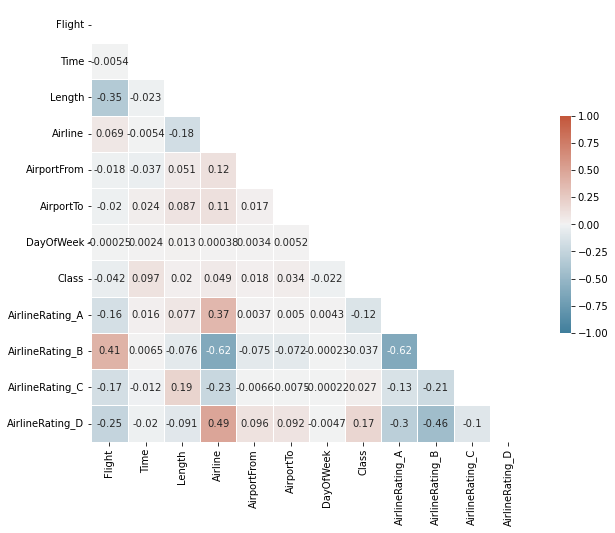

In [148]:
corr = df_1.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(12, 8))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           )
plt.show()

Сильных корреляций между признаками не наблюдается. Однако теперь мы имеем ряд признаков, которые имеют большую корреляцию с целевой переменной. Можно также заметить, что наибольшую корреляцию целевая переменная имеет с рейтингом 'A' и 'D', в то время как для 'B' и 'C' корреляция довольно низкая.

In [44]:
X = df_1.drop('Class', axis = 1)
y = df_1['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

object = StandardScaler() 
X_train.iloc[:, [1, 2]] = object.fit_transform(X_train.iloc[:, [1, 2]])

X_test.iloc[:, [1, 2]] = object.transform(X_test.iloc[:, [1, 2]])

In [45]:
rf = RandomForestClassifier(n_estimators = 54, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.59
precision = 0.32
recall = 0.64
roc_auc = 0.61
f1 = 0.43


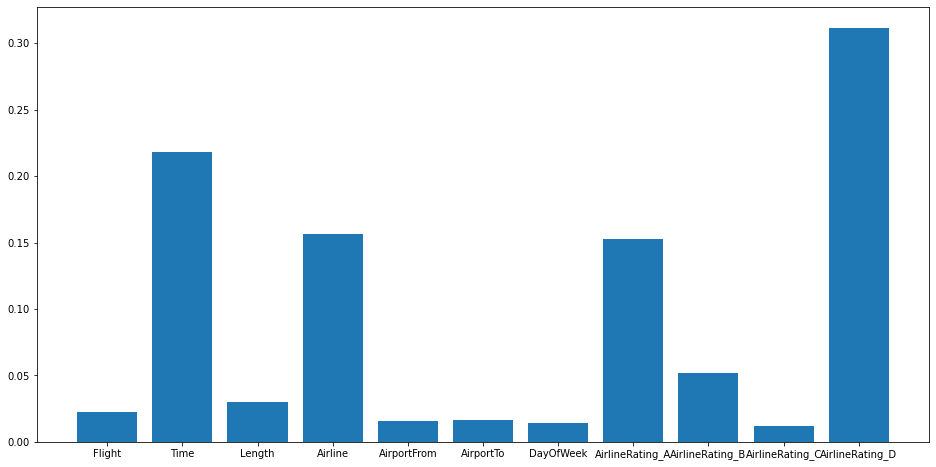

In [46]:
plt.figure(figsize = (16, 8))
plt.bar(X.columns, rf.feature_importances_);

In [37]:
delayed_part = {}

for i in df['Airline'].unique():
    delayed_part[i] = df[df['Airline'] == i]['Class'].mean()
    
parts = np.array(list(delayed_part.values()))

delta = (np.max(parts) - np.min(parts)) / 3
A = np.min(parts) + delta
B = np.min(parts) + 2 * delta

delayed_rating = {'A' : [], 'B' : [], 'C' : []}
for i in delayed_part:
    if delayed_part[i] < A:
        delayed_rating['A'].append(i)
    elif (delayed_part[i] >= A) and (delayed_part[i] < B):
        delayed_rating['B'].append(i)
    else:
        delayed_rating['C'].append(i)
        
df_1 = df.copy()

df_1['AirlineRating_A'] = np.where(df_1['Airline'].isin(delayed_rating['A']), 1, 0)
df_1['AirlineRating_B'] = np.where(df_1['Airline'].isin(delayed_rating['B']), 1, 0)
df_1['AirlineRating_C'] = np.where(df_1['Airline'].isin(delayed_rating['C']), 1, 0)

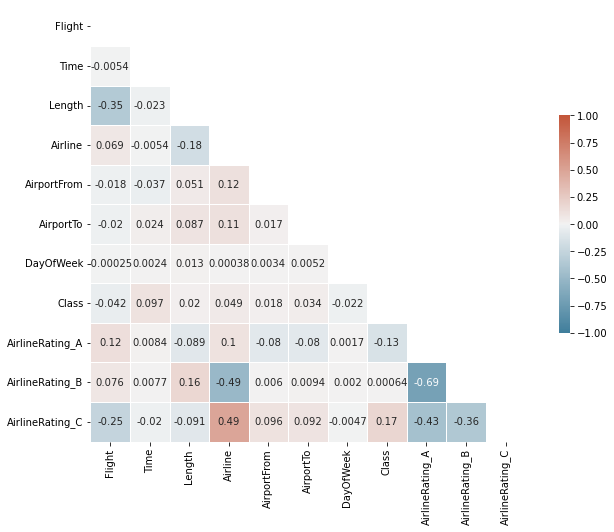

In [38]:
corr = df_1.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(12, 8))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           )
plt.show()

In [39]:
X = df_1.drop('Class', axis = 1)
y = df_1['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

object = StandardScaler() 
X_train.iloc[:, [1, 2]] = object.fit_transform(X_train.iloc[:, [1, 2]])

X_test.iloc[:, [1, 2]] = object.transform(X_test.iloc[:, [1, 2]])

rf = RandomForestClassifier(n_estimators = 54, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.59
precision = 0.4
recall = 0.61
roc_auc = 0.6
f1 = 0.48


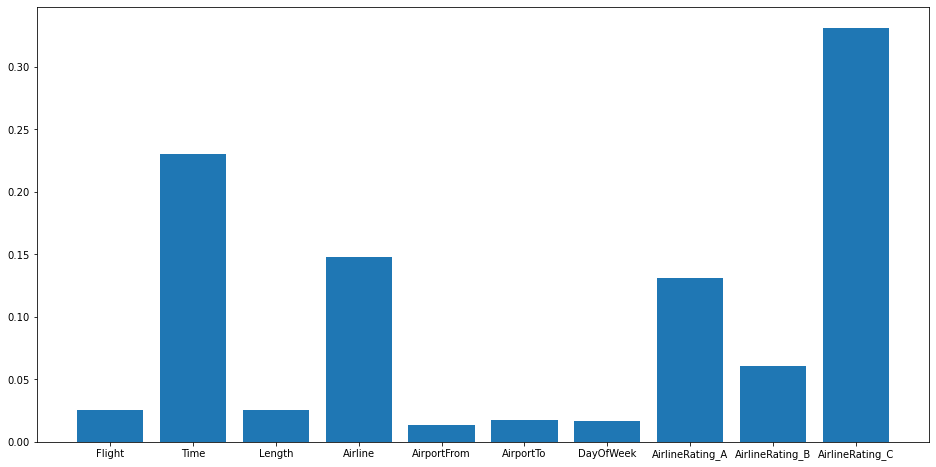

In [40]:
plt.figure(figsize = (16, 8))
plt.bar(X.columns, rf.feature_importances_);

Метрики prcision и f1 выросли, но доля правильных ответов осталась без изменений. При этом разбиение на 3 группы по рейтингу дало лучший результат по сравнению с 4-мя. Также в ходу данной работы я пробовал разбивать на большее количество групп, но в этом случае метрики становились ниже. В целом по значимости признаков мы видим, что данное разбиение по рейтингам позволило добавить признаки имеющие влияние на целевую переменную. На данном этапе мы не будем осуществлять перебор по сетке ввиду трудоемкости данной операции, а также по причине того, что пока мы не имеем достаточное количество признаков для нормального предсказания целевой переменной.

In [41]:
len(df_1['Flight'].unique())

6585

In [42]:
len(df_1['Flight'])

322764

Возможно стоит попробовать провести аналогичное разбиение по рейтингам для номеров рейсов, т.к. некоторые могут задерживаться чаще остальных.

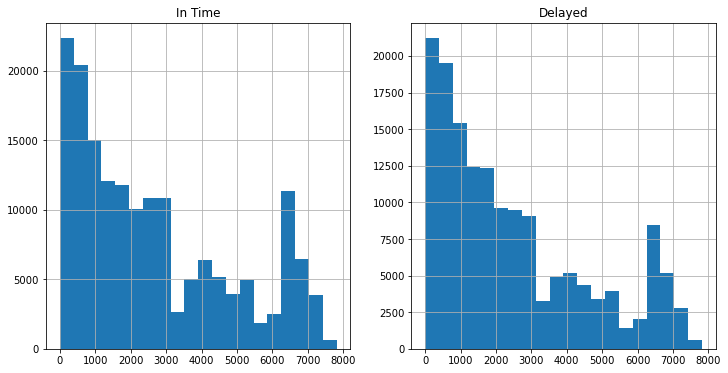

In [43]:
fig, axs = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)

axs[0].hist(df[df['Class'] == 0]['Flight'], bins = 20)
axs[0].set_title('In Time')
axs[0].grid()
axs[1].hist(df[df['Class'] == 1]['Flight'], bins = 20)
axs[1].grid()
axs[1].set_title('Delayed');

In [44]:
delayed_part = {}

for i in df['Flight'].unique():
    delayed_part[i] = df[df['Flight'] == i]['Class'].mean()
    
parts = np.array(list(delayed_part.values()))
print(sorted(parts))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.07692307692307693, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.1111111111111111, 0.1111111111111111, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.13333333333333333, 0.13333333333333333, 0.13636363636363635, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.15, 0.15384615384615385, 0.15384615384615385, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.17647058823529413, 0.17647058823529413, 0.17647058823529413, 0.17647058823529413, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.18181818181818182, 0.1875, 0.1875, 0.19230769230769232, 0.19230769230769232, 0.19230769230769232, 0.1935483870967742, 0.2, 0.2, 0.2, 0.2, 0.2

По полученным результатам видно, что некоторые рейсы не задерживаются никогда, а некоторые в 100% случаев. Попробуем разбить по данному признаку на 10 групп рейтинга.

In [45]:
delayed_part = {}

for i in df['Flight'].unique():
    delayed_part[i] = df[df['Flight'] == i]['Class'].mean()
    
parts = np.array(list(delayed_part.values()))

delta = (np.max(parts) - np.min(parts)) / 10
A = np.min(parts) + delta
B = np.min(parts) + 2 * delta
C = np.min(parts) + 3 * delta
D = np.min(parts) + 4 * delta
E = np.min(parts) + 5 * delta
F = np.min(parts) + 6 * delta
G = np.min(parts) + 7 * delta
H = np.min(parts) + 8 * delta
I = np.min(parts) + 9 * delta

delayed_rating = {'A' : [], 'B' : [], 'C' : [], 'D' : [], 'E' : [], 'F' : [], 'G' : [], 'H' : [], 'I' : [], 'J' : [],  }
for i in delayed_part:
    if delayed_part[i] < A:
        delayed_rating['A'].append(i)
    elif (delayed_part[i] >= A) and (delayed_part[i] < B):
        delayed_rating['B'].append(i)
    elif (delayed_part[i] >= B) and (delayed_part[i] < C):
        delayed_rating['C'].append(i)
    elif (delayed_part[i] >= C) and (delayed_part[i] < D):
        delayed_rating['D'].append(i)
    elif (delayed_part[i] >= D) and (delayed_part[i] < E):
        delayed_rating['E'].append(i)
    elif (delayed_part[i] >= E) and (delayed_part[i] < F):
        delayed_rating['F'].append(i)
    elif (delayed_part[i] >= F) and (delayed_part[i] < H):
        delayed_rating['H'].append(i)
    elif (delayed_part[i] >= H) and (delayed_part[i] < I):
        delayed_rating['I'].append(i)
    else:
        delayed_rating['J'].append(i)        

df_1['FlightRating_A'] = np.where(df_1['Flight'].isin(delayed_rating['A']), 1, 0)
df_1['FlightRating_B'] = np.where(df_1['Flight'].isin(delayed_rating['B']), 1, 0)
df_1['FlightRating_C'] = np.where(df_1['Flight'].isin(delayed_rating['C']), 1, 0)
df_1['FlightRating_D'] = np.where(df_1['Flight'].isin(delayed_rating['D']), 1, 0)
df_1['FlightRating_E'] = np.where(df_1['Flight'].isin(delayed_rating['E']), 1, 0)
df_1['FlightRating_F'] = np.where(df_1['Flight'].isin(delayed_rating['F']), 1, 0)
df_1['FlightRating_G'] = np.where(df_1['Flight'].isin(delayed_rating['G']), 1, 0)
df_1['FlightRating_H'] = np.where(df_1['Flight'].isin(delayed_rating['H']), 1, 0)
df_1['FlightRating_I'] = np.where(df_1['Flight'].isin(delayed_rating['I']), 1, 0)
df_1['FlightRating_J'] = np.where(df_1['Flight'].isin(delayed_rating['J']), 1, 0)

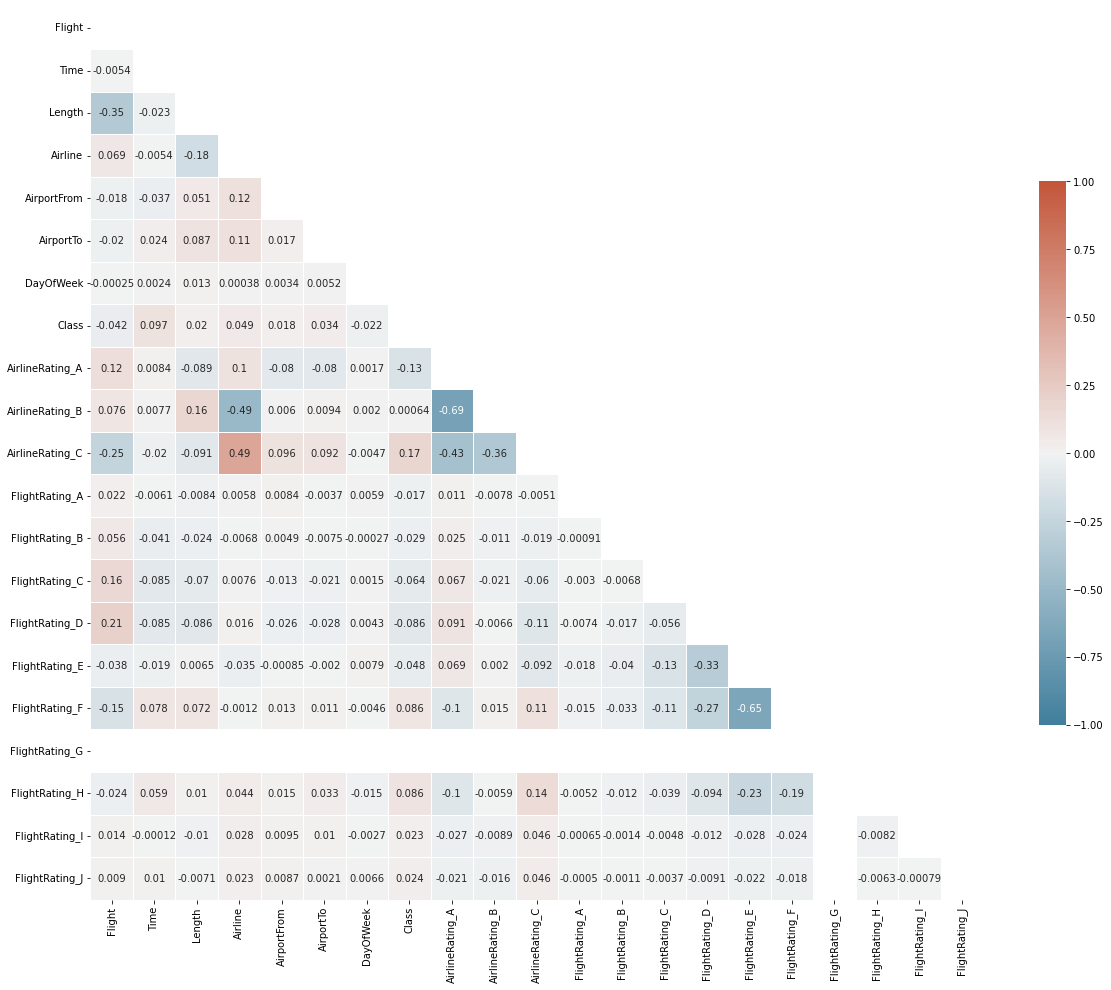

In [46]:
corr = df_1.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           )
plt.show()

In [47]:
X = df_1.drop(['Class'], axis = 1)
y = df_1['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

object = StandardScaler() 
X_train.iloc[:, [1, 2]] = object.fit_transform(X_train.iloc[:, [1, 2]])

X_test.iloc[:, [1, 2]] = object.transform(X_test.iloc[:, [1, 2]])

rf = RandomForestClassifier(n_estimators = 54, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.6
precision = 0.4
recall = 0.62
roc_auc = 0.6
f1 = 0.49


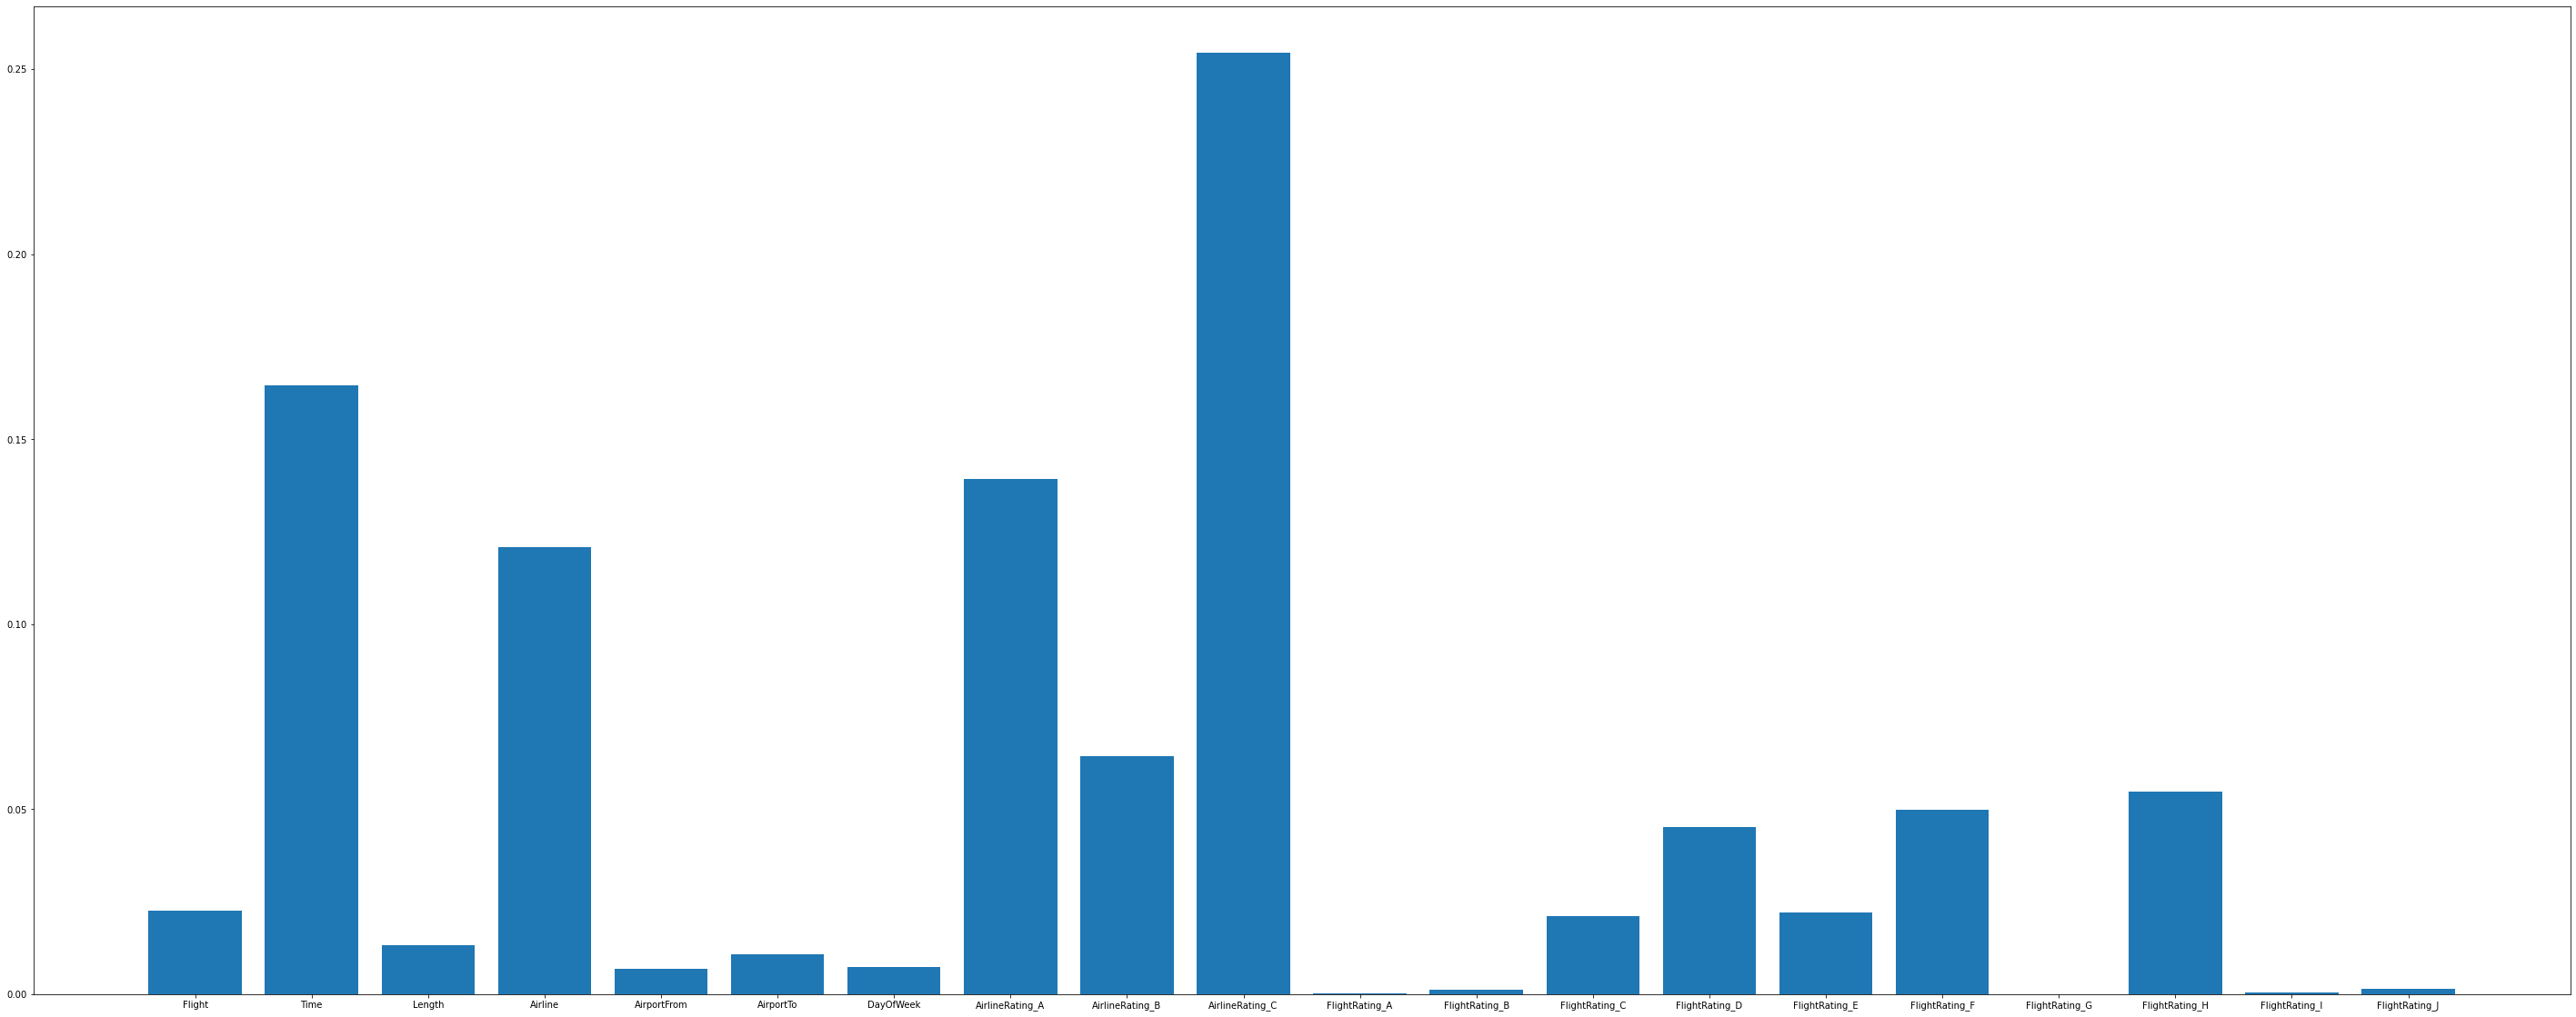

In [48]:
plt.figure(figsize = (50, 20))
plt.bar(X.columns, rf.feature_importances_);

Качество модели стало чуть-чуть лучше. Удалим неинформативные признаки.

In [49]:
X = df_1.drop(['Class', 'FlightRating_A', 'FlightRating_B', 'FlightRating_G', 'FlightRating_I', 'FlightRating_J'], axis = 1)
y = df_1['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

object = StandardScaler() 
X_train.iloc[:, [1, 2]] = object.fit_transform(X_train.iloc[:, [1, 2]])

X_test.iloc[:, [1, 2]] = object.transform(X_test.iloc[:, [1, 2]])

rf = RandomForestClassifier(n_estimators = 54, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.6
precision = 0.41
recall = 0.62
roc_auc = 0.6
f1 = 0.49


Метрика precision выросла на 0,01. Остальные метрики не изменились.

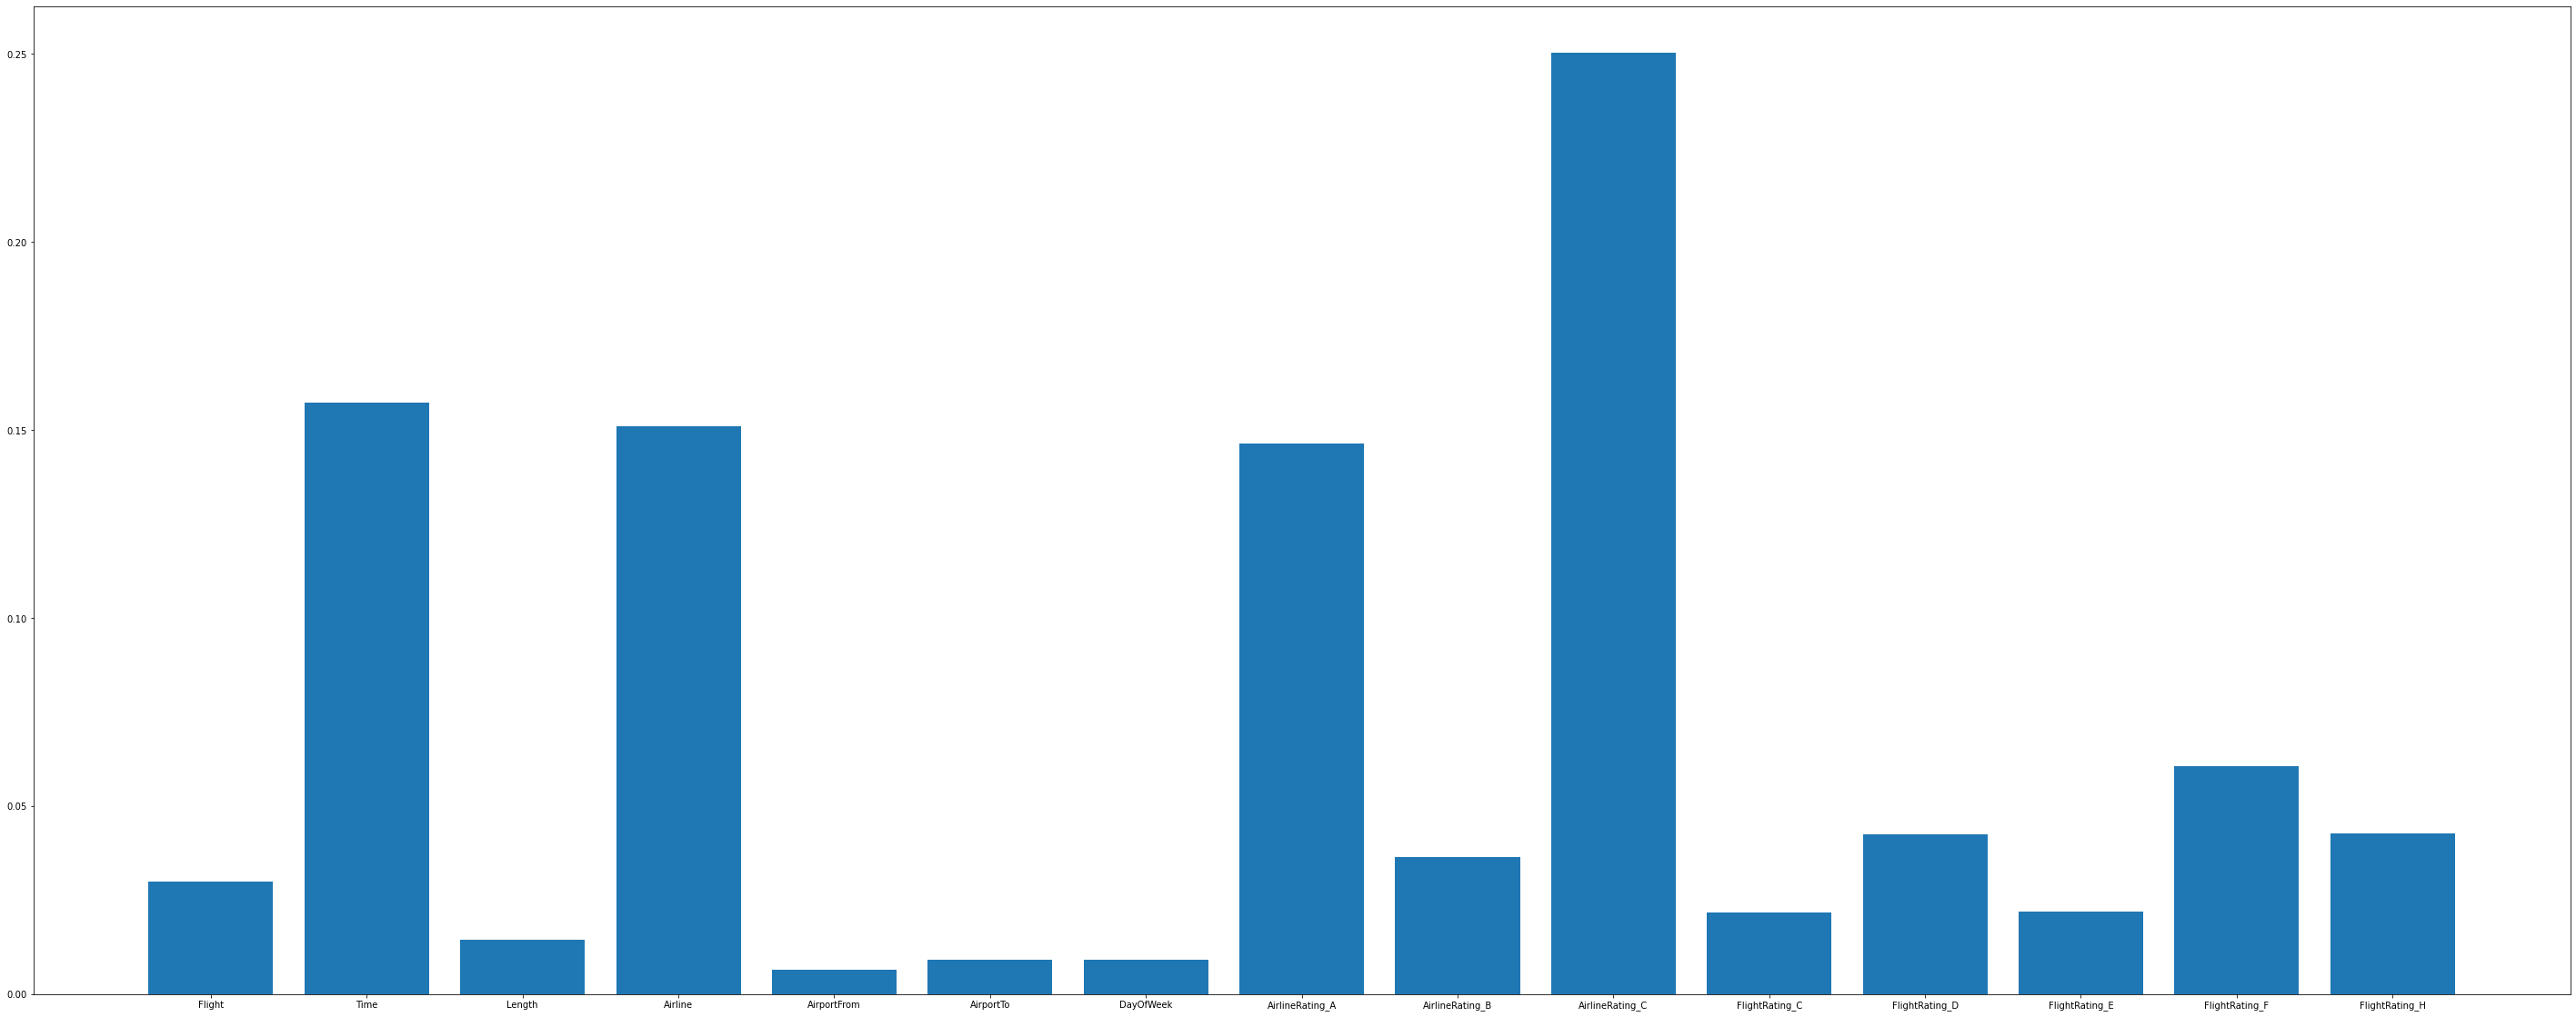

In [50]:
plt.figure(figsize = (50, 20))
plt.bar(X.columns, rf.feature_importances_);

Добавим признак, указывающий является ли день недели выходных или нет. 

In [51]:
df_1 = df_1.drop(['FlightRating_A', 'FlightRating_B', 'FlightRating_G', 'FlightRating_I', 'FlightRating_J'], axis = 1)

In [62]:
df_1['Weekend'] = np.where(df_1['DayOfWeek'].isin([6, 7]), 1, 0)

In [63]:
X = df_1.drop(['Class'], axis = 1)
y = df_1['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

object = StandardScaler() 
X_train.iloc[:, [1, 2]] = object.fit_transform(X_train.iloc[:, [1, 2]])

X_test.iloc[:, [1, 2]] = object.transform(X_test.iloc[:, [1, 2]])

rf = RandomForestClassifier(n_estimators = 54, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.6
precision = 0.4
recall = 0.62
roc_auc = 0.6
f1 = 0.48


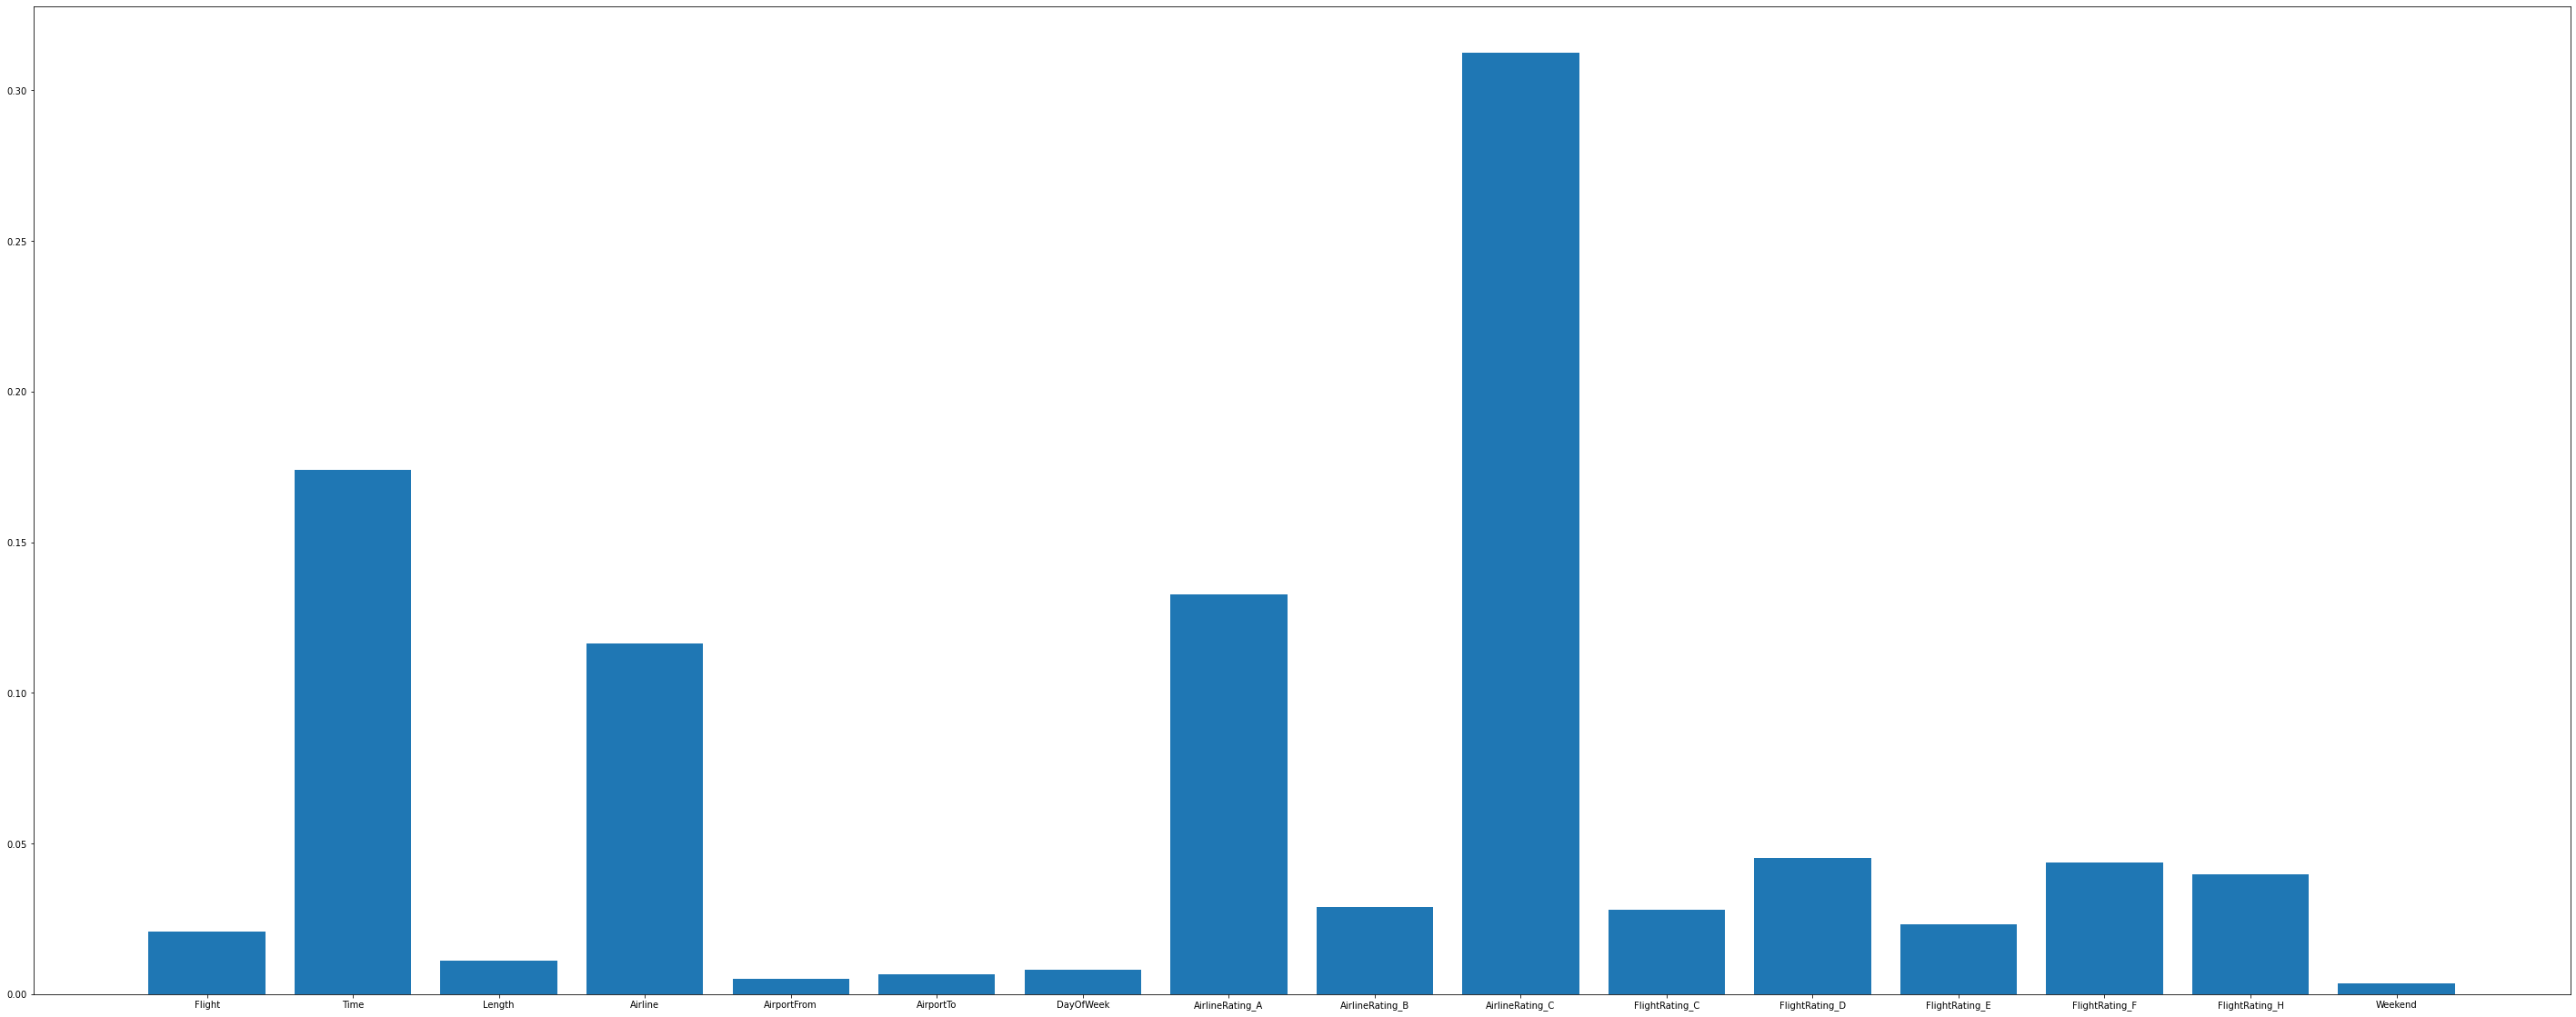

In [64]:
plt.figure(figsize = (50, 20))
plt.bar(X.columns, rf.feature_importances_);

Признак 'Weekend' оказался неинформативным и немного ухудшил качество модели. Его следует убрать.

In [65]:
df_1 = df_1.drop('Weekend', axis = 1)

Наибольший дисбаланс классов наблюдался в субботу. Попробуем добавить признак, говорящий о том, является ли день недели субботой, т.к. возможно именно для этого дня недели модели потребуются дополнительные вычисления.

In [66]:
df_1['Saturday'] = np.where(df_1['DayOfWeek'] == 6, 1, 0)

In [67]:
X = df_1.drop(['Class'], axis = 1)
y = df_1['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

object = StandardScaler() 
X_train.iloc[:, [1, 2]] = object.fit_transform(X_train.iloc[:, [1, 2]])

X_test.iloc[:, [1, 2]] = object.transform(X_test.iloc[:, [1, 2]])

rf = RandomForestClassifier(n_estimators = 54, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.6
precision = 0.4
recall = 0.62
roc_auc = 0.6
f1 = 0.48


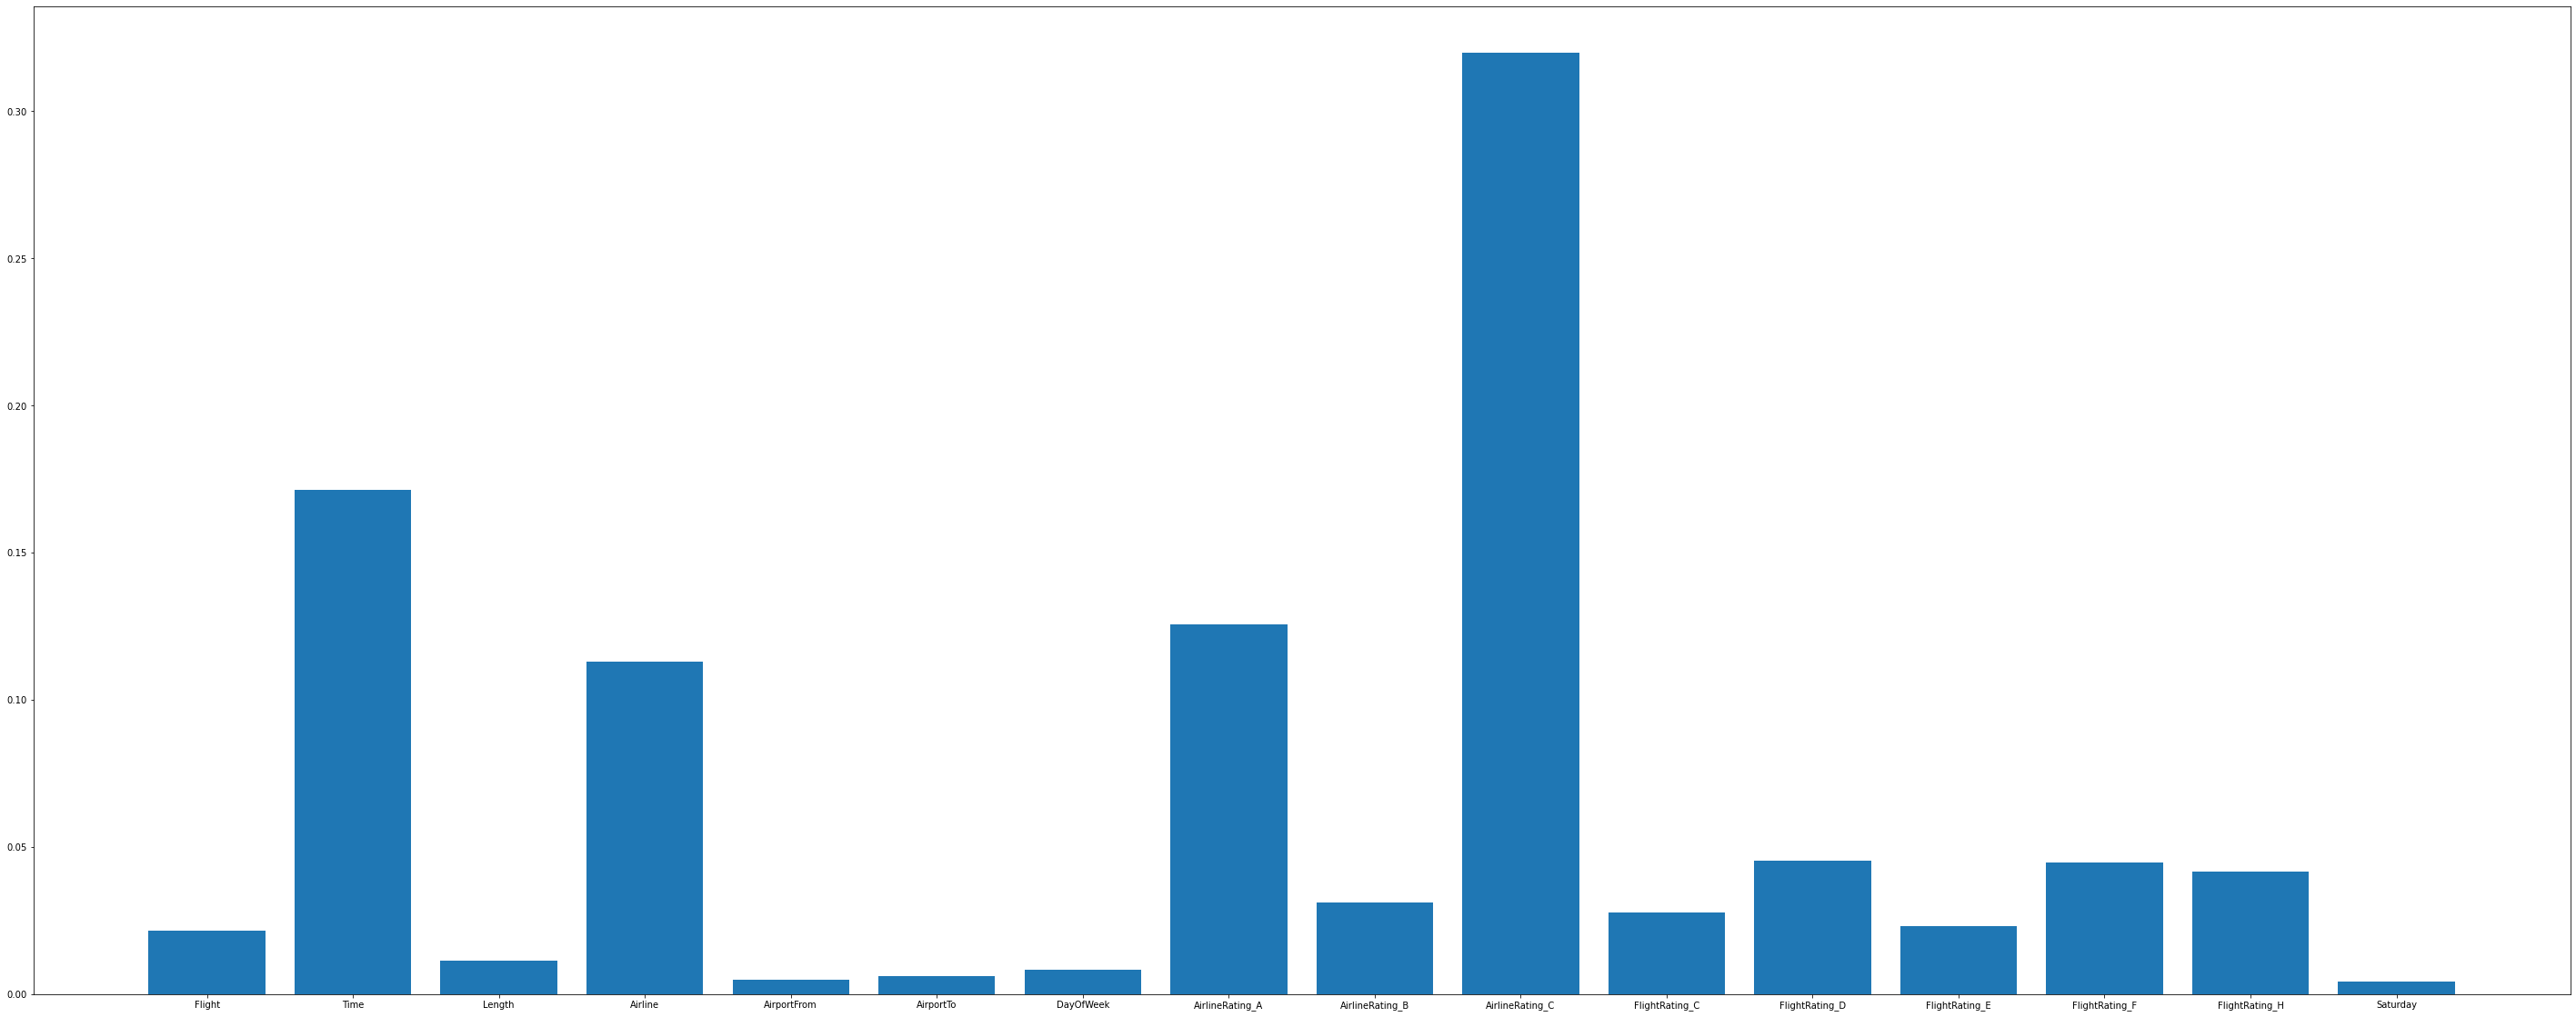

In [68]:
plt.figure(figsize = (50, 20))
plt.bar(X.columns, rf.feature_importances_);

Признак оказался незначимым и немного ухудших качество модели. Удалим его.

In [69]:
df_1 = df_1.drop('Saturday', axis = 1)

Попробуем проанализировать признак Time и сгенерировать на основе него новые признаки.

In [70]:
len(df_1['Time'].unique())

1131

Признак 'Time' является одним из ключевых. Попробуем разбить его на группы. Сам признак содержит в себе информацию о номере минуты в сутках, в которую происходит вылет. Возможно результаты будут лучше, если учитывать более крупные временные интервалы, в которые происходит вылет, например, интервалы в 1 час или более крупные. 

Создадим признак, который будет содержать номер часа в сутках, в который происходит вылет.

In [71]:
df_1['hour'] = df_1['Time'] // 60

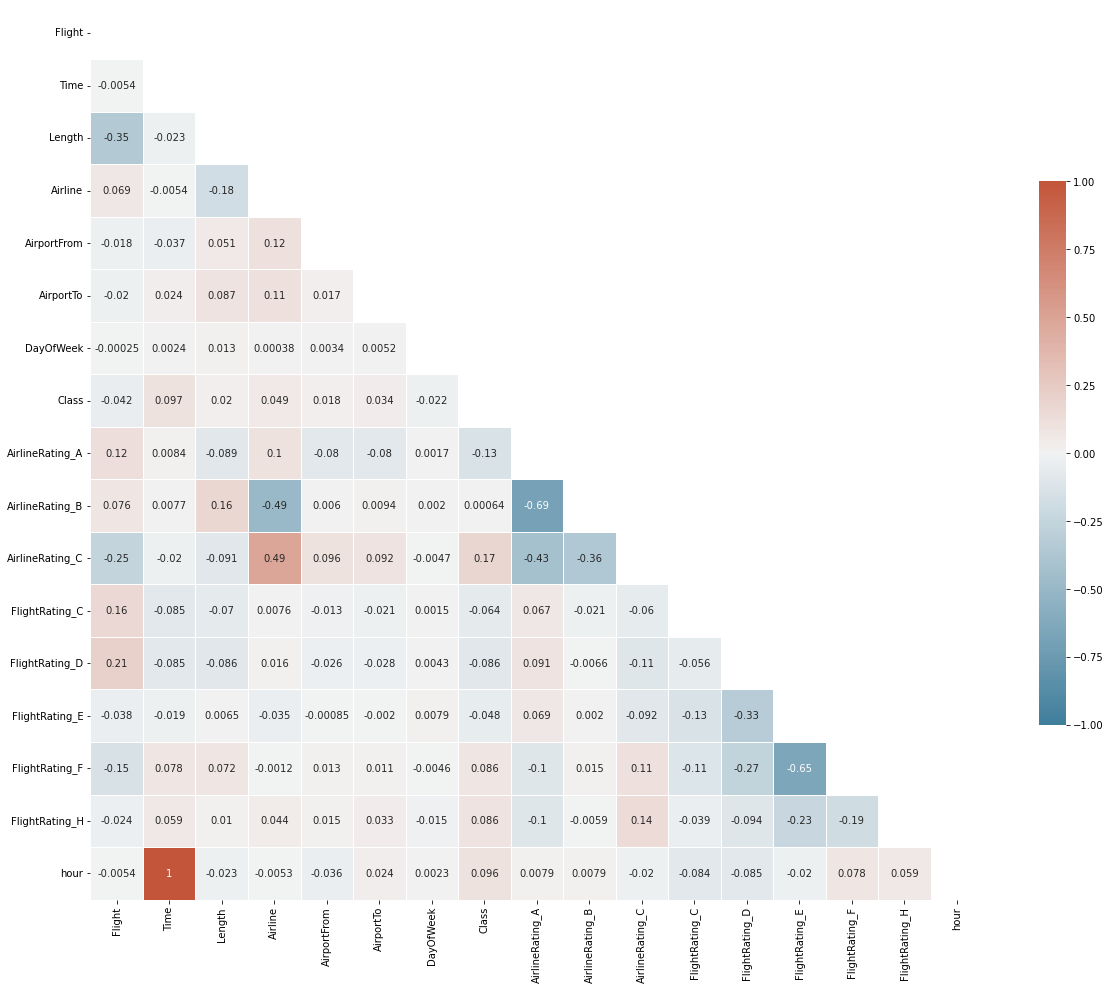

In [72]:
corr = df_1.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           )
plt.show()

In [73]:
X = df_1.drop(['Class'], axis = 1)
y = df_1['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

object = StandardScaler() 
X_train.iloc[:, [1, 2]] = object.fit_transform(X_train.iloc[:, [1, 2]])

X_test.iloc[:, [1, 2]] = object.transform(X_test.iloc[:, [1, 2]])

rf = RandomForestClassifier(n_estimators = 54, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.6
precision = 0.4
recall = 0.62
roc_auc = 0.6
f1 = 0.49


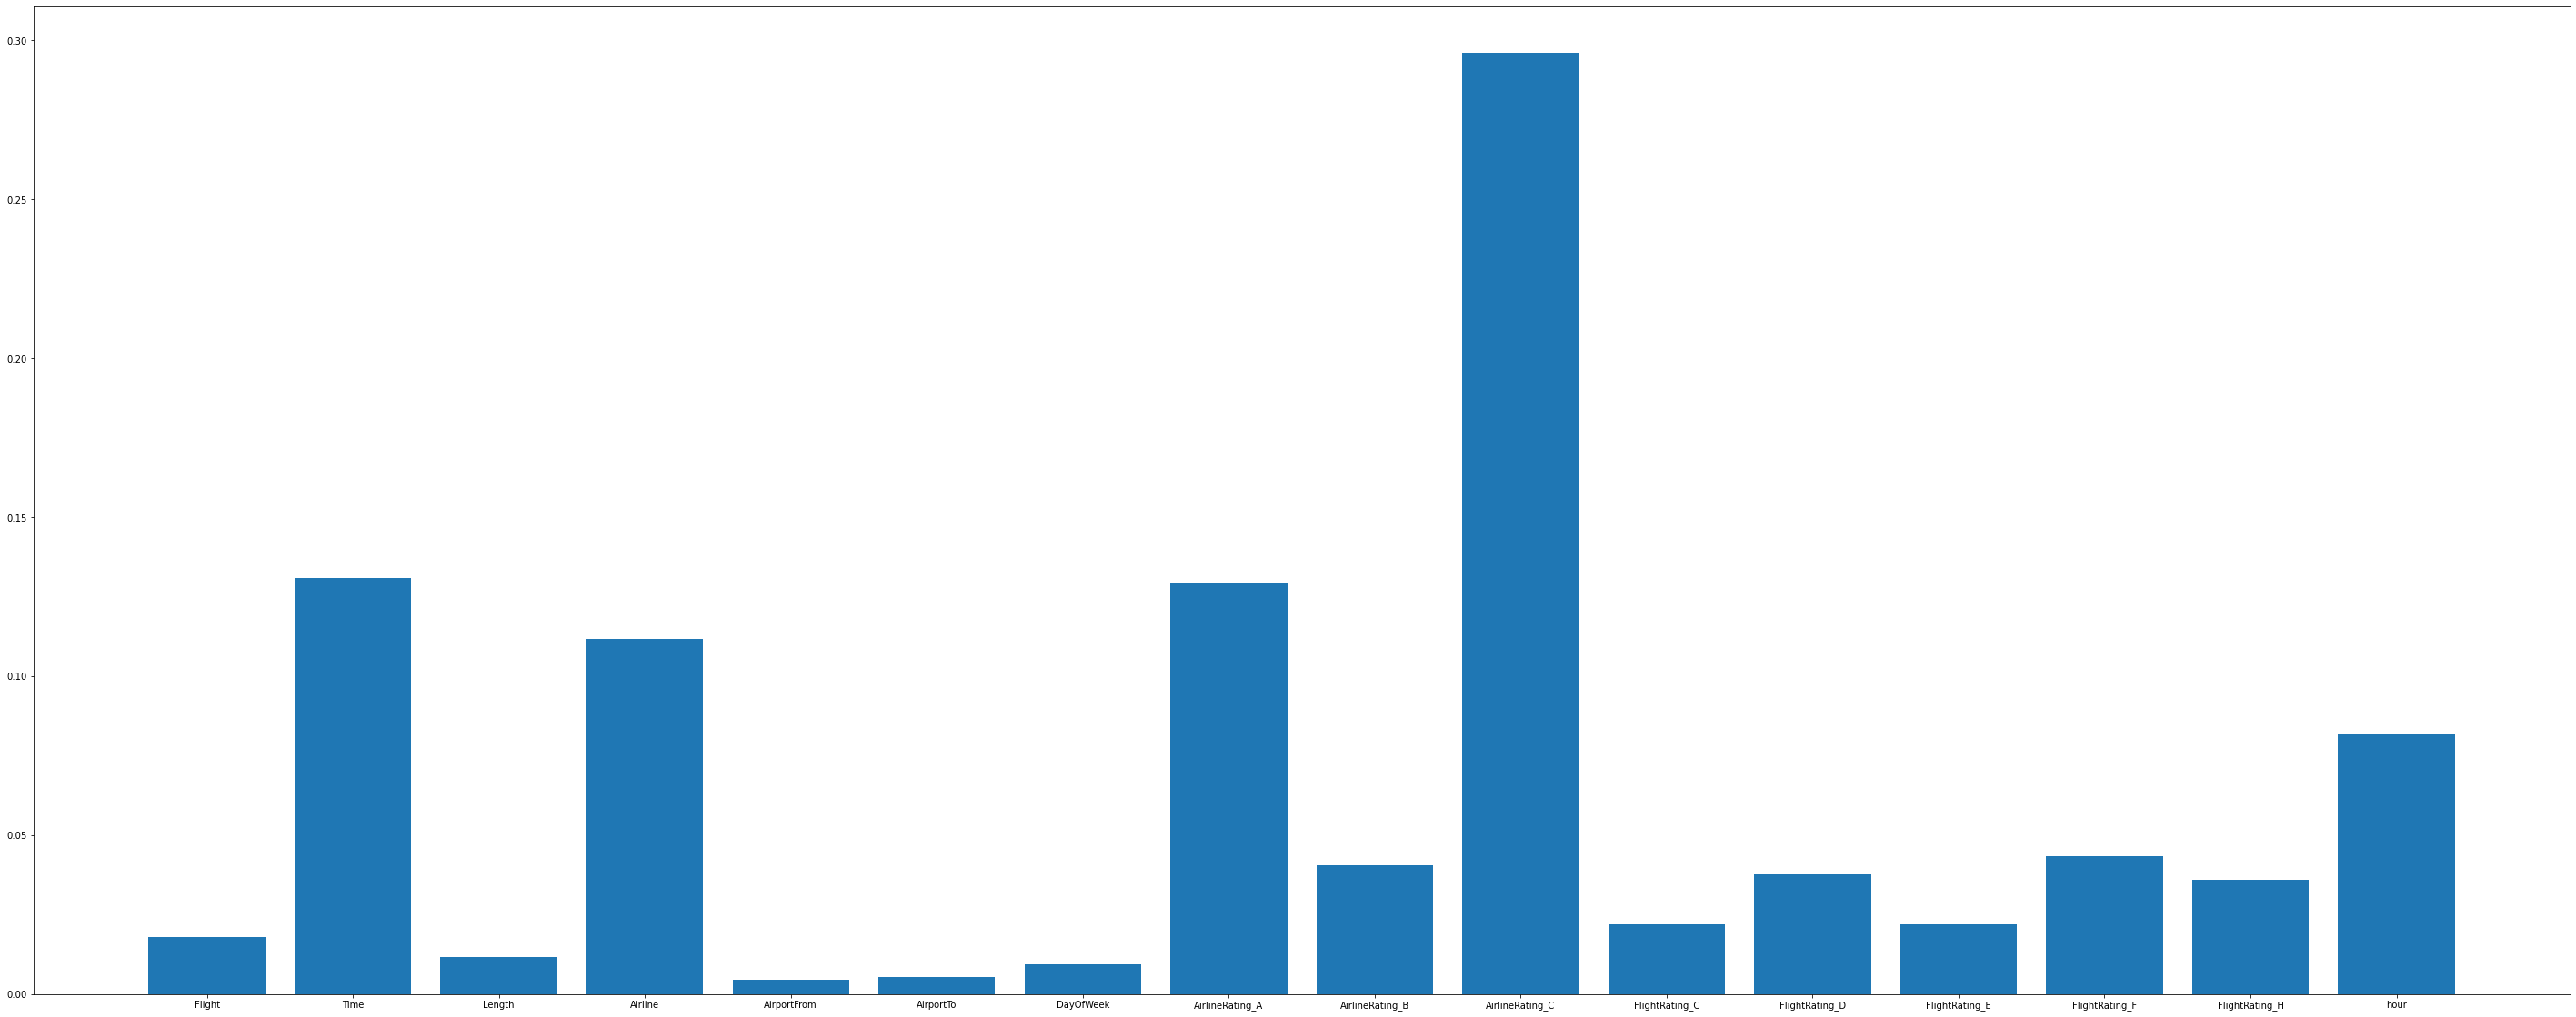

In [74]:
plt.figure(figsize = (50, 20))
plt.bar(X.columns, rf.feature_importances_);

Качество модели не улучшилось, но при этом мы получили признак линейно зависимый от признака 'Time'. Его стоит убрать.

In [75]:
df_1 = df_1.drop('hour', axis = 1)

По гистограммам полученным ранее мы можем видеть, что в сутках есть временные периоды, в которые наибольшее количество задержанных рейсов, а есть и те, в которых наименьшее. Попробуем разбить на группы в зависимости от этого.

In [52]:
delayed_part = {}

for i in df['Time'].unique():
    delayed_part[i] = df[df['Time'] == i]['Class'].mean()
    
parts = np.array(list(delayed_part.values()))
print(sorted(parts))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09090909090909091, 0.09090909090909091, 0.11538461538461539, 0.125, 0.14285714285714285, 0.14285714285714285, 0.16666666666666666, 0.16666666666666666, 0.1724137931034483, 0.17647058823529413, 0.1791044776119403, 0.18421052631578946, 0.19148936170212766, 0.2, 0.2, 0.21052631578947367, 0.21739130434782608, 0.21951219512195122, 0.2222222222222222, 0.2222222222222222, 0.2222222222222222, 0.2222222222222222, 0.2222222222222222, 0.22448979591836735, 0.22916666666666666, 0.2318840579710145, 0.23529411764705882, 0.23529411764705882, 0.23809523809523808, 0.24444444444444444, 0.25, 0.25, 0.25, 0.25, 0.2571428571428571, 0.25925925925925924, 0.26, 0.2608695652173913, 0.2608695652173913, 0.26666666666666666, 0.2676056338028169, 0.26881720430107525, 0.2692307692307692, 0.2708333333333333, 0.2727272727272727, 0.2765957446808511, 0.2777777777777778, 0.28, 0.2840909090909091, 0.2857142857142857, 0.2857142857142857, 0.285714285714

In [53]:
delta = (np.max(parts) - np.min(parts)) / 10
A = np.min(parts) + delta
B = np.min(parts) + 2 * delta
C = np.min(parts) + 3 * delta
D = np.min(parts) + 4 * delta
E = np.min(parts) + 5 * delta
F = np.min(parts) + 6 * delta
G = np.min(parts) + 7 * delta
H = np.min(parts) + 8 * delta
I = np.min(parts) + 9 * delta

delayed_rating = {'A' : [], 'B' : [], 'C' : [], 'D' : [], 'E' : [], 'F' : [], 'G' : [], 'H' : [], 'I' : [], 'J' : [],  }
for i in delayed_part:
    if delayed_part[i] < A:
        delayed_rating['A'].append(i)
    elif (delayed_part[i] >= A) and (delayed_part[i] < B):
        delayed_rating['B'].append(i)
    elif (delayed_part[i] >= B) and (delayed_part[i] < C):
        delayed_rating['C'].append(i)
    elif (delayed_part[i] >= C) and (delayed_part[i] < D):
        delayed_rating['D'].append(i)
    elif (delayed_part[i] >= D) and (delayed_part[i] < E):
        delayed_rating['E'].append(i)
    elif (delayed_part[i] >= E) and (delayed_part[i] < F):
        delayed_rating['F'].append(i)
    elif (delayed_part[i] >= F) and (delayed_part[i] < H):
        delayed_rating['H'].append(i)
    elif (delayed_part[i] >= H) and (delayed_part[i] < I):
        delayed_rating['I'].append(i)
    else:
        delayed_rating['J'].append(i)        

df_1['TimeRating_A'] = np.where(df_1['Time'].isin(delayed_rating['A']), 1, 0)
df_1['TimeRating_B'] = np.where(df_1['Time'].isin(delayed_rating['B']), 1, 0)
df_1['TimeRating_C'] = np.where(df_1['Time'].isin(delayed_rating['C']), 1, 0)
df_1['TimeRating_D'] = np.where(df_1['Time'].isin(delayed_rating['D']), 1, 0)
df_1['TimeRating_E'] = np.where(df_1['Time'].isin(delayed_rating['E']), 1, 0)
df_1['TimeRating_F'] = np.where(df_1['Time'].isin(delayed_rating['F']), 1, 0)
df_1['TimeRating_G'] = np.where(df_1['Time'].isin(delayed_rating['G']), 1, 0)
df_1['TimeRating_H'] = np.where(df_1['Time'].isin(delayed_rating['H']), 1, 0)
df_1['TimeRating_I'] = np.where(df_1['Time'].isin(delayed_rating['I']), 1, 0)
df_1['TimeRating_J'] = np.where(df_1['Time'].isin(delayed_rating['J']), 1, 0)

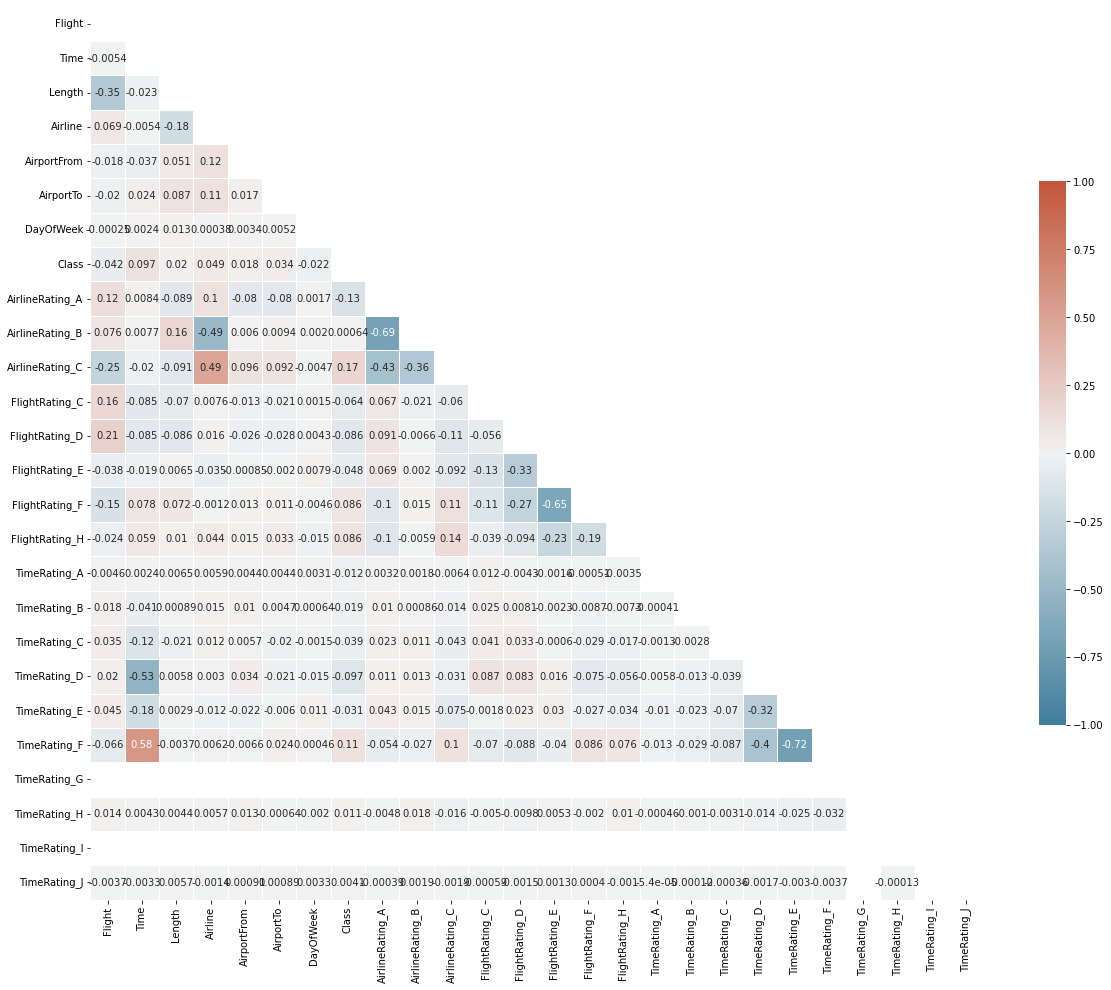

In [54]:
corr = df_1.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           );

Можно заметить, что с большей часитю таймрейтингов корреляция очень слабая. Посмотрим на результаты модели, и попробуем отбросить ряд признаков.

In [55]:
X = df_1.drop(['Class'], axis = 1)
y = df_1['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

object = StandardScaler() 
X_train.iloc[:, [1, 2]] = object.fit_transform(X_train.iloc[:, [1, 2]])

X_test.iloc[:, [1, 2]] = object.transform(X_test.iloc[:, [1, 2]])

rf = RandomForestClassifier(n_estimators = 54, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.6
precision = 0.39
recall = 0.62
roc_auc = 0.61
f1 = 0.48


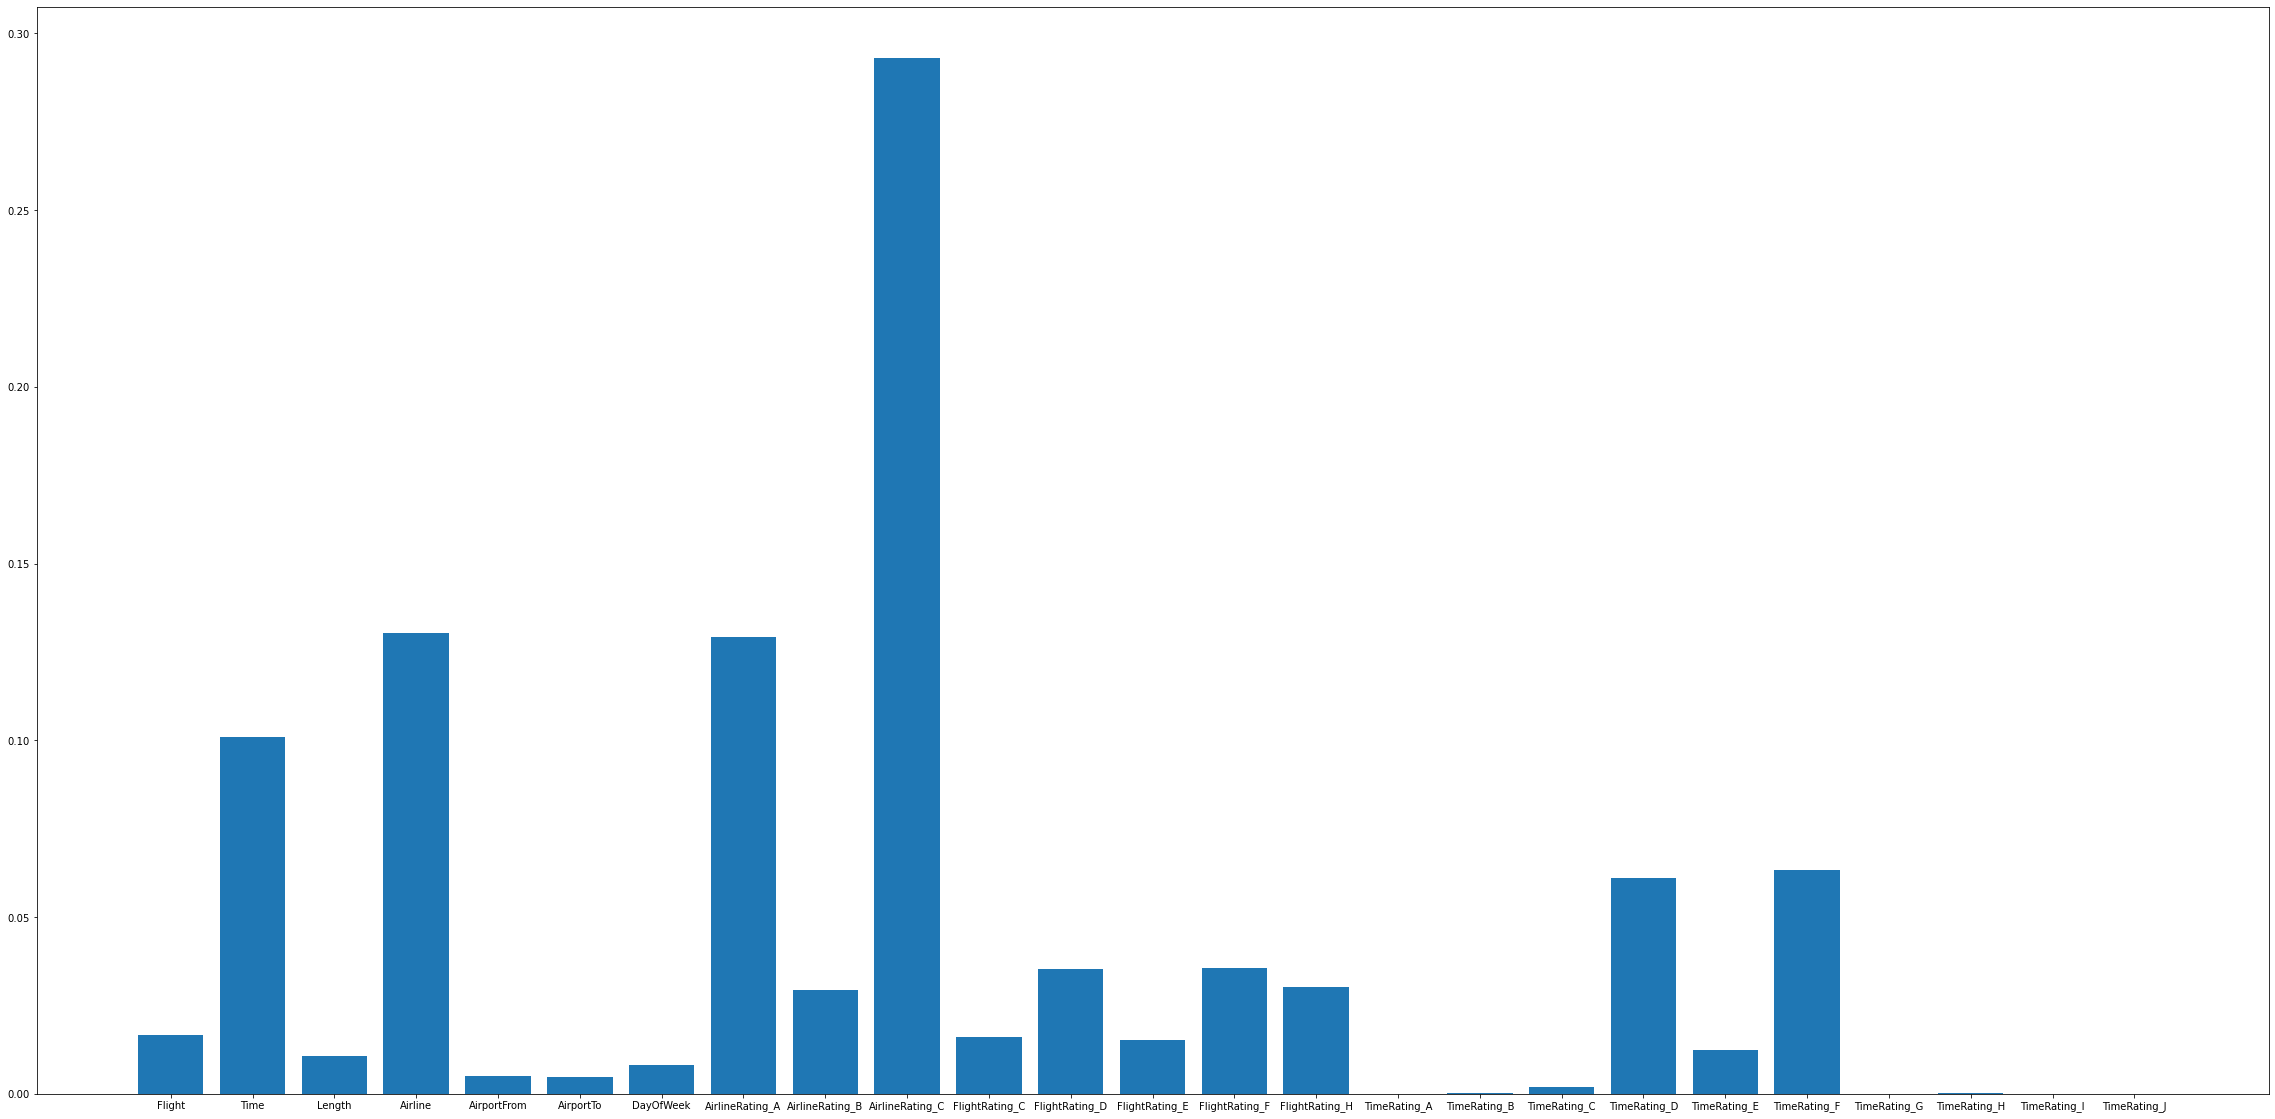

In [56]:
plt.figure(figsize = (40, 20))
plt.bar(X.columns, rf.feature_importances_);

Значимыми оказались только рейтинги D, E, F.

In [57]:
X = df_1.drop(['Class', 'TimeRating_A', 'TimeRating_B', 'TimeRating_C', 'TimeRating_G', 'TimeRating_H', 'TimeRating_I', 'TimeRating_J'], axis = 1)
y = df_1['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

object = StandardScaler() 
X_train.iloc[:, [1, 2]] = object.fit_transform(X_train.iloc[:, [1, 2]])

X_test.iloc[:, [1, 2]] = object.transform(X_test.iloc[:, [1, 2]])

rf = RandomForestClassifier(n_estimators = 54, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.6
precision = 0.39
recall = 0.62
roc_auc = 0.61
f1 = 0.48


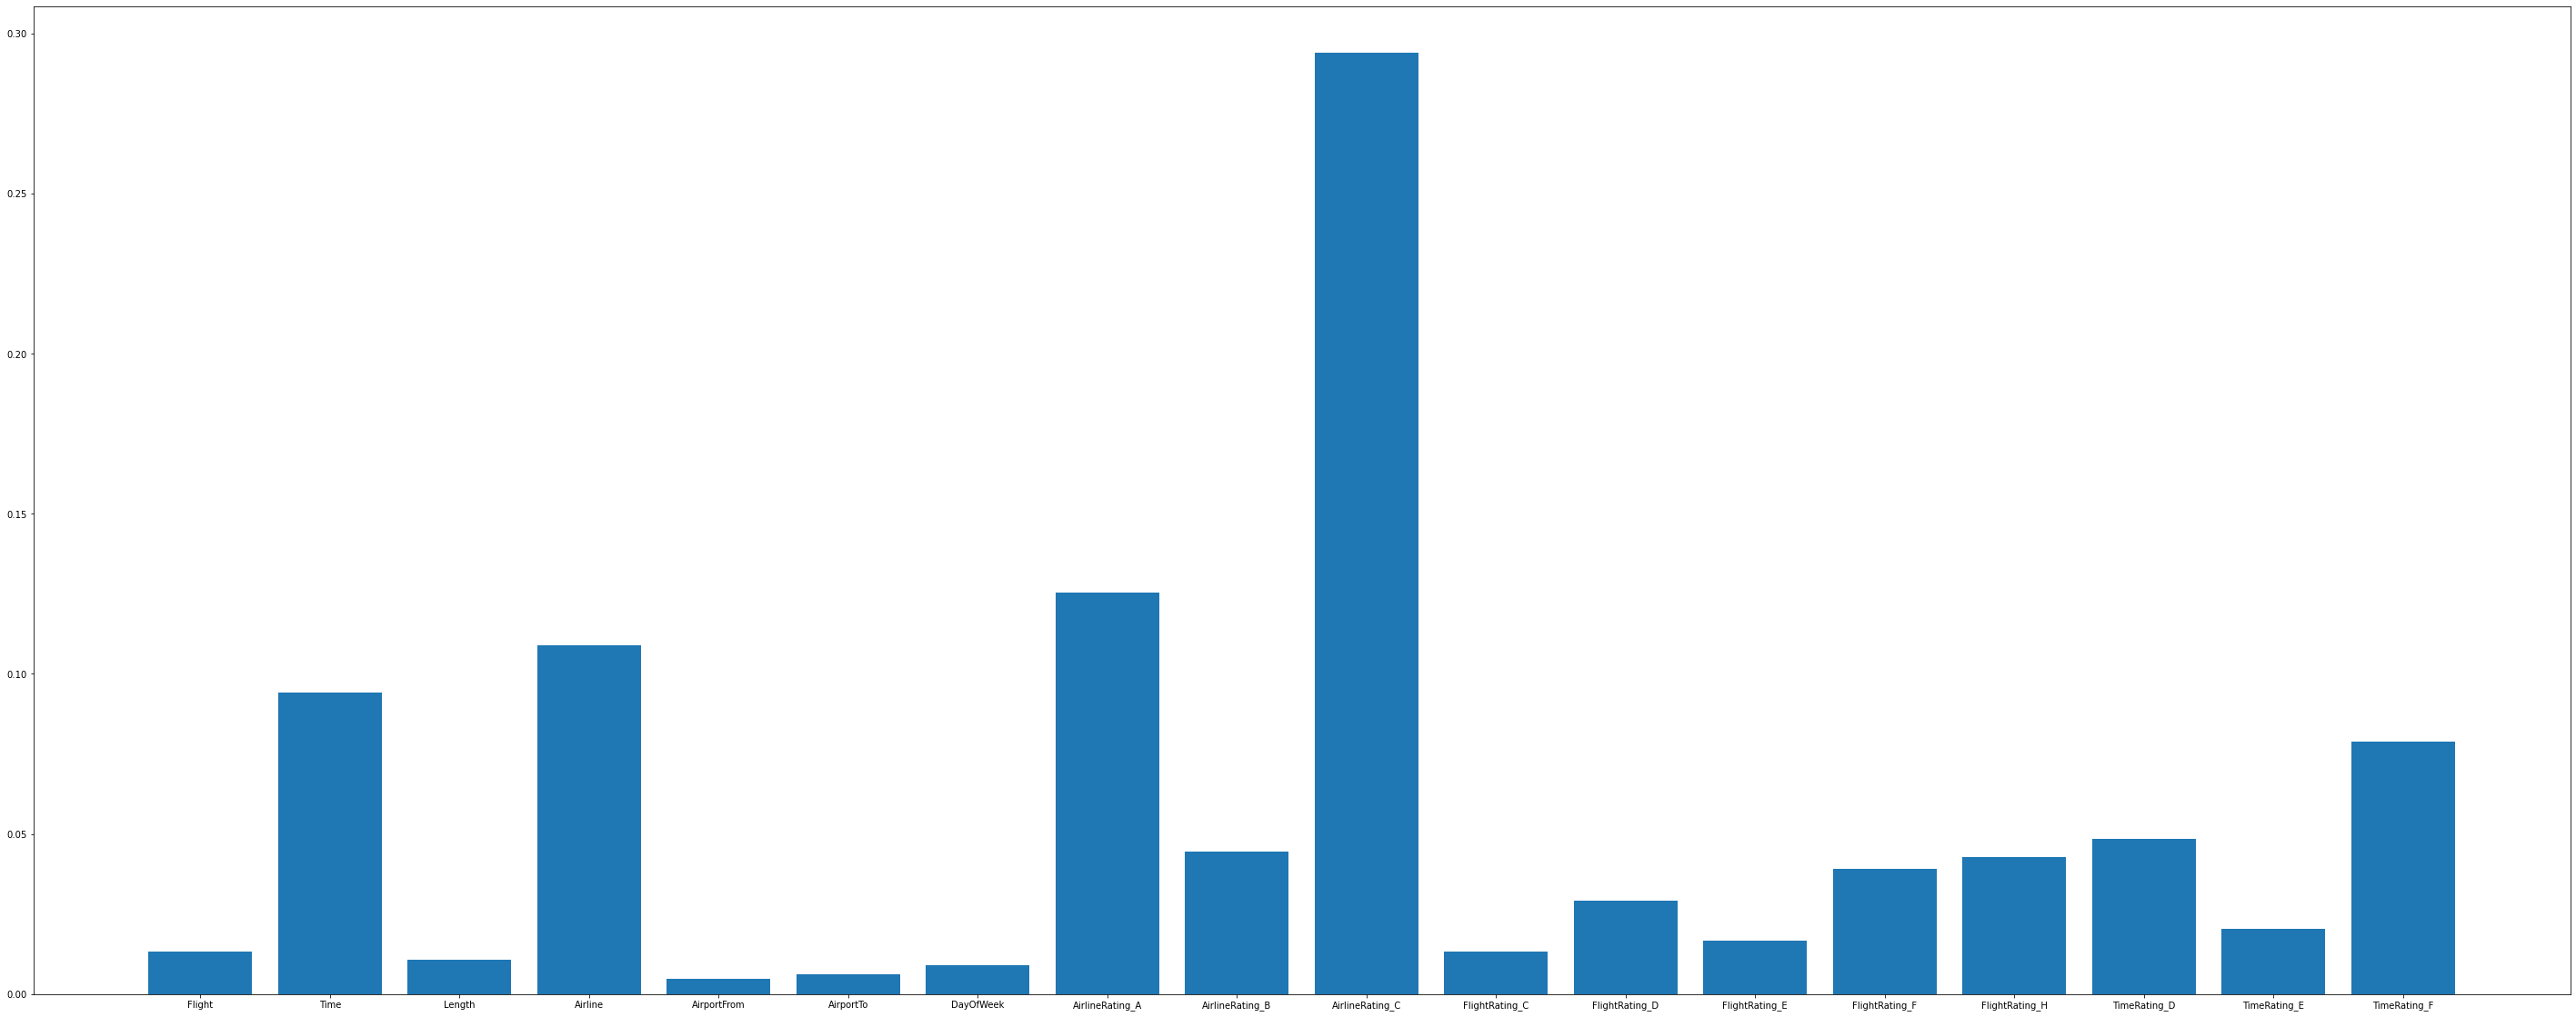

In [58]:
plt.figure(figsize = (50, 20))
plt.bar(X.columns, rf.feature_importances_);

Попробуем объединить рейтинги D, E, F в один.

In [59]:
df_1 = df_1.drop(['TimeRating_A', 'TimeRating_B', 'TimeRating_C', 'TimeRating_G', 
                  'TimeRating_H', 'TimeRating_I', 'TimeRating_J'], axis = 1)

In [60]:
df_1['TimeRating'] = df_1['TimeRating_D'] + df_1['TimeRating_E'] + df_1['TimeRating_F']

In [61]:
df_1 = df_1.drop(['TimeRating_D', 'TimeRating_E', 'TimeRating_F'], axis = 1)

In [62]:
X = df_1.drop(['Class'], axis = 1)
y = df_1['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

object = StandardScaler() 
X_train.iloc[:, [1, 2]] = object.fit_transform(X_train.iloc[:, [1, 2]])

X_test.iloc[:, [1, 2]] = object.transform(X_test.iloc[:, [1, 2]])

rf = RandomForestClassifier(n_estimators = 54, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.6
precision = 0.4
recall = 0.62
roc_auc = 0.6
f1 = 0.49


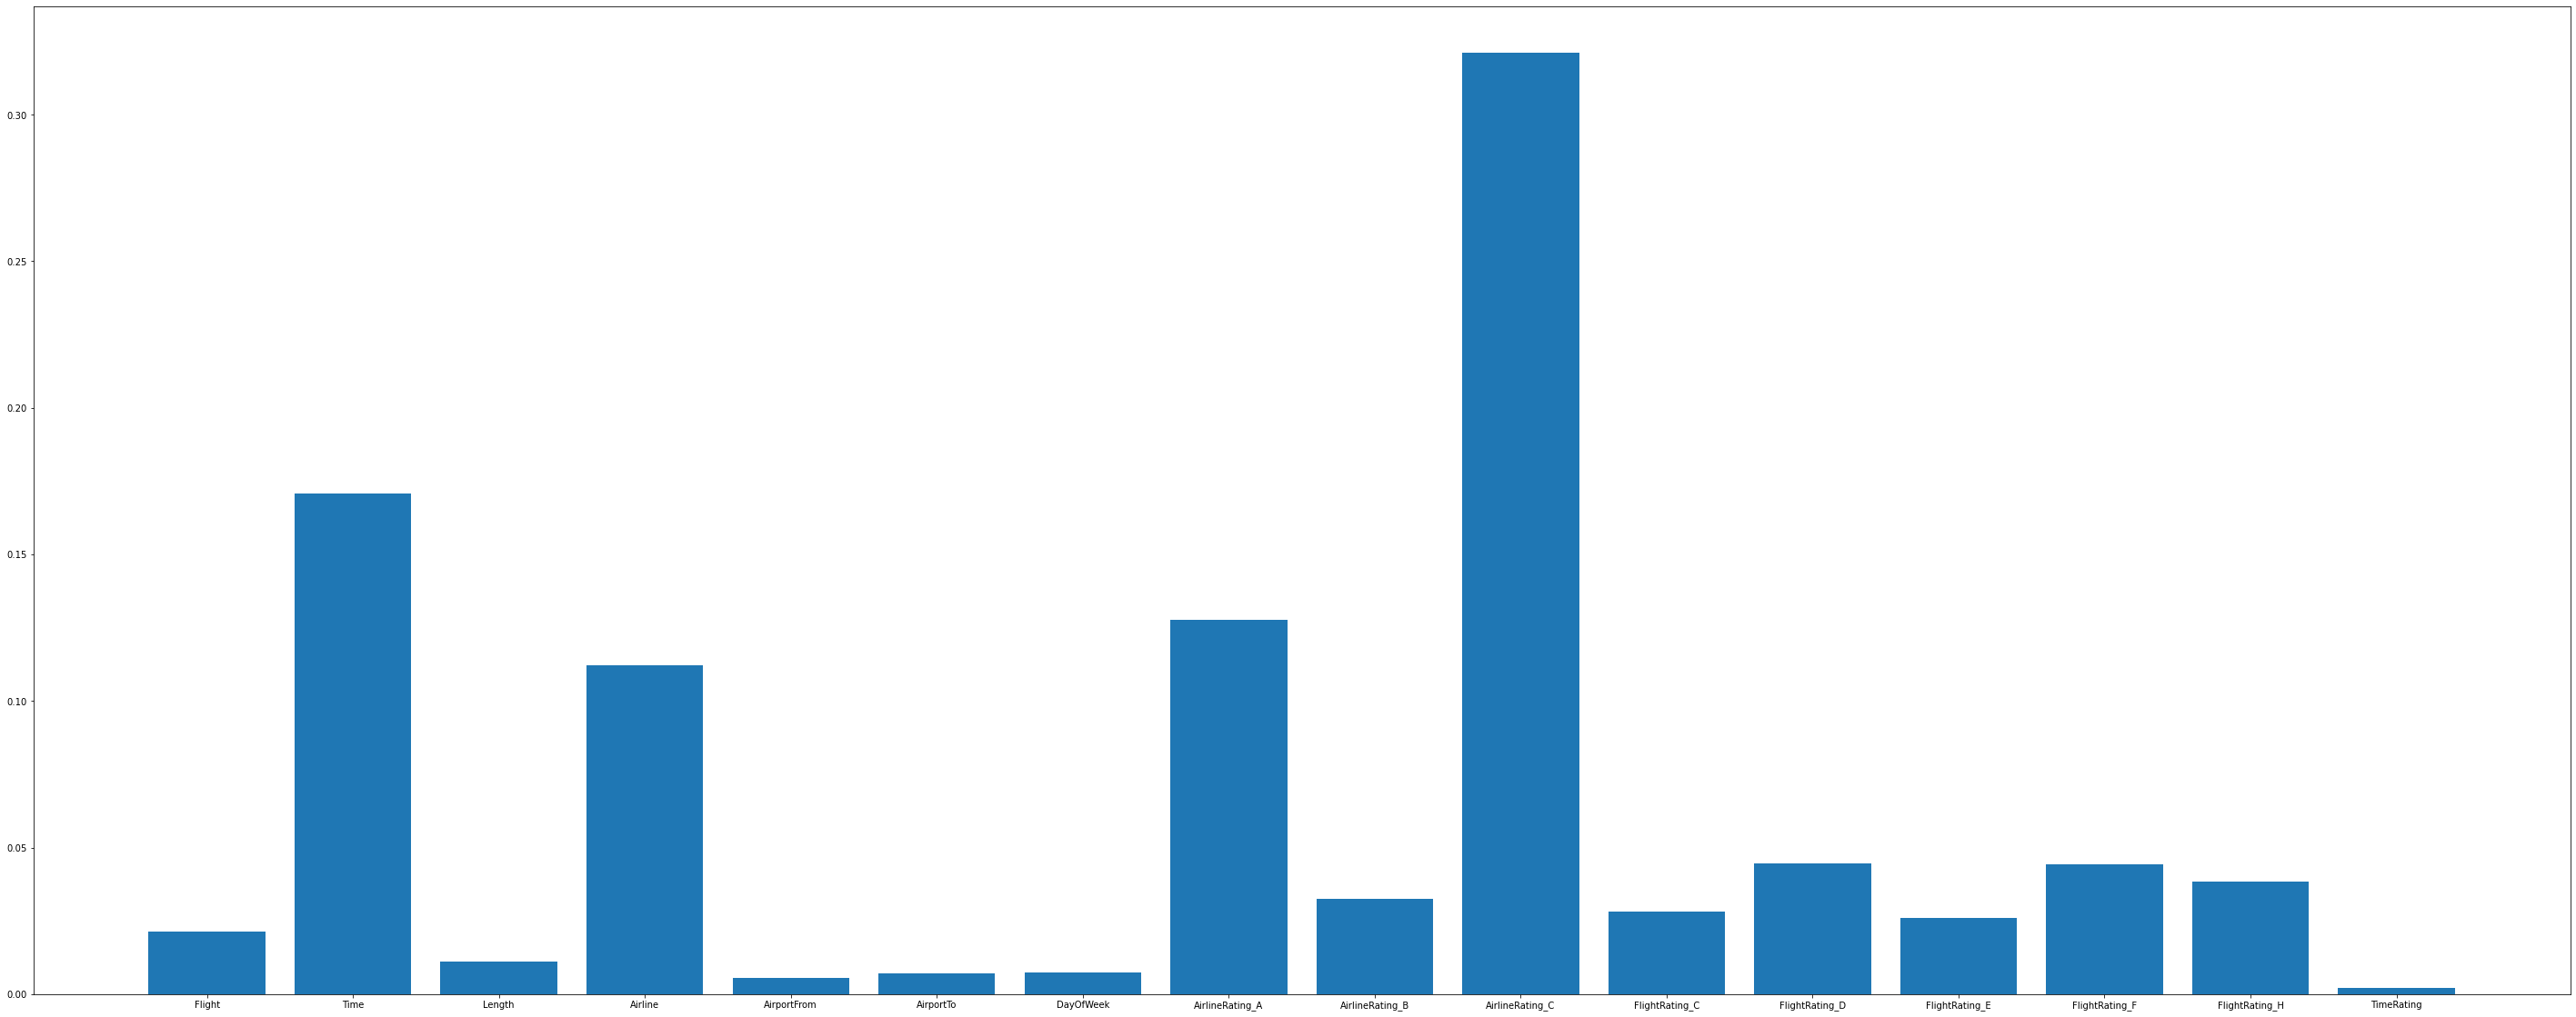

In [63]:
plt.figure(figsize = (50, 20))
plt.bar(X.columns, rf.feature_importances_);

Новый признак не дал никаких улучшений. Удалим его.

In [64]:
df_1 = df_1.drop(['TimeRating'], axis = 1)

По гистограммам построенным ранее мы наблюдали, что приблизительно после 900 минуты количество задержанных рейсов сильно возрастает. Попробуем создать 2 признака (ранний перелет и поздний перелет).

In [65]:
df_1['Early'] = np.where(df_1['Time'] < 900, 1, 0)
df_1['Late'] = np.where(df_1['Time'] >= 900, 1, 0)

In [66]:
X = df_1.drop(['Class'], axis = 1)
y = df_1['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

object = StandardScaler() 
X_train.iloc[:, [1, 2]] = object.fit_transform(X_train.iloc[:, [1, 2]])

X_test.iloc[:, [1, 2]] = object.transform(X_test.iloc[:, [1, 2]])

rf = RandomForestClassifier(n_estimators = 54, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.6
precision = 0.41
recall = 0.62
roc_auc = 0.6
f1 = 0.49


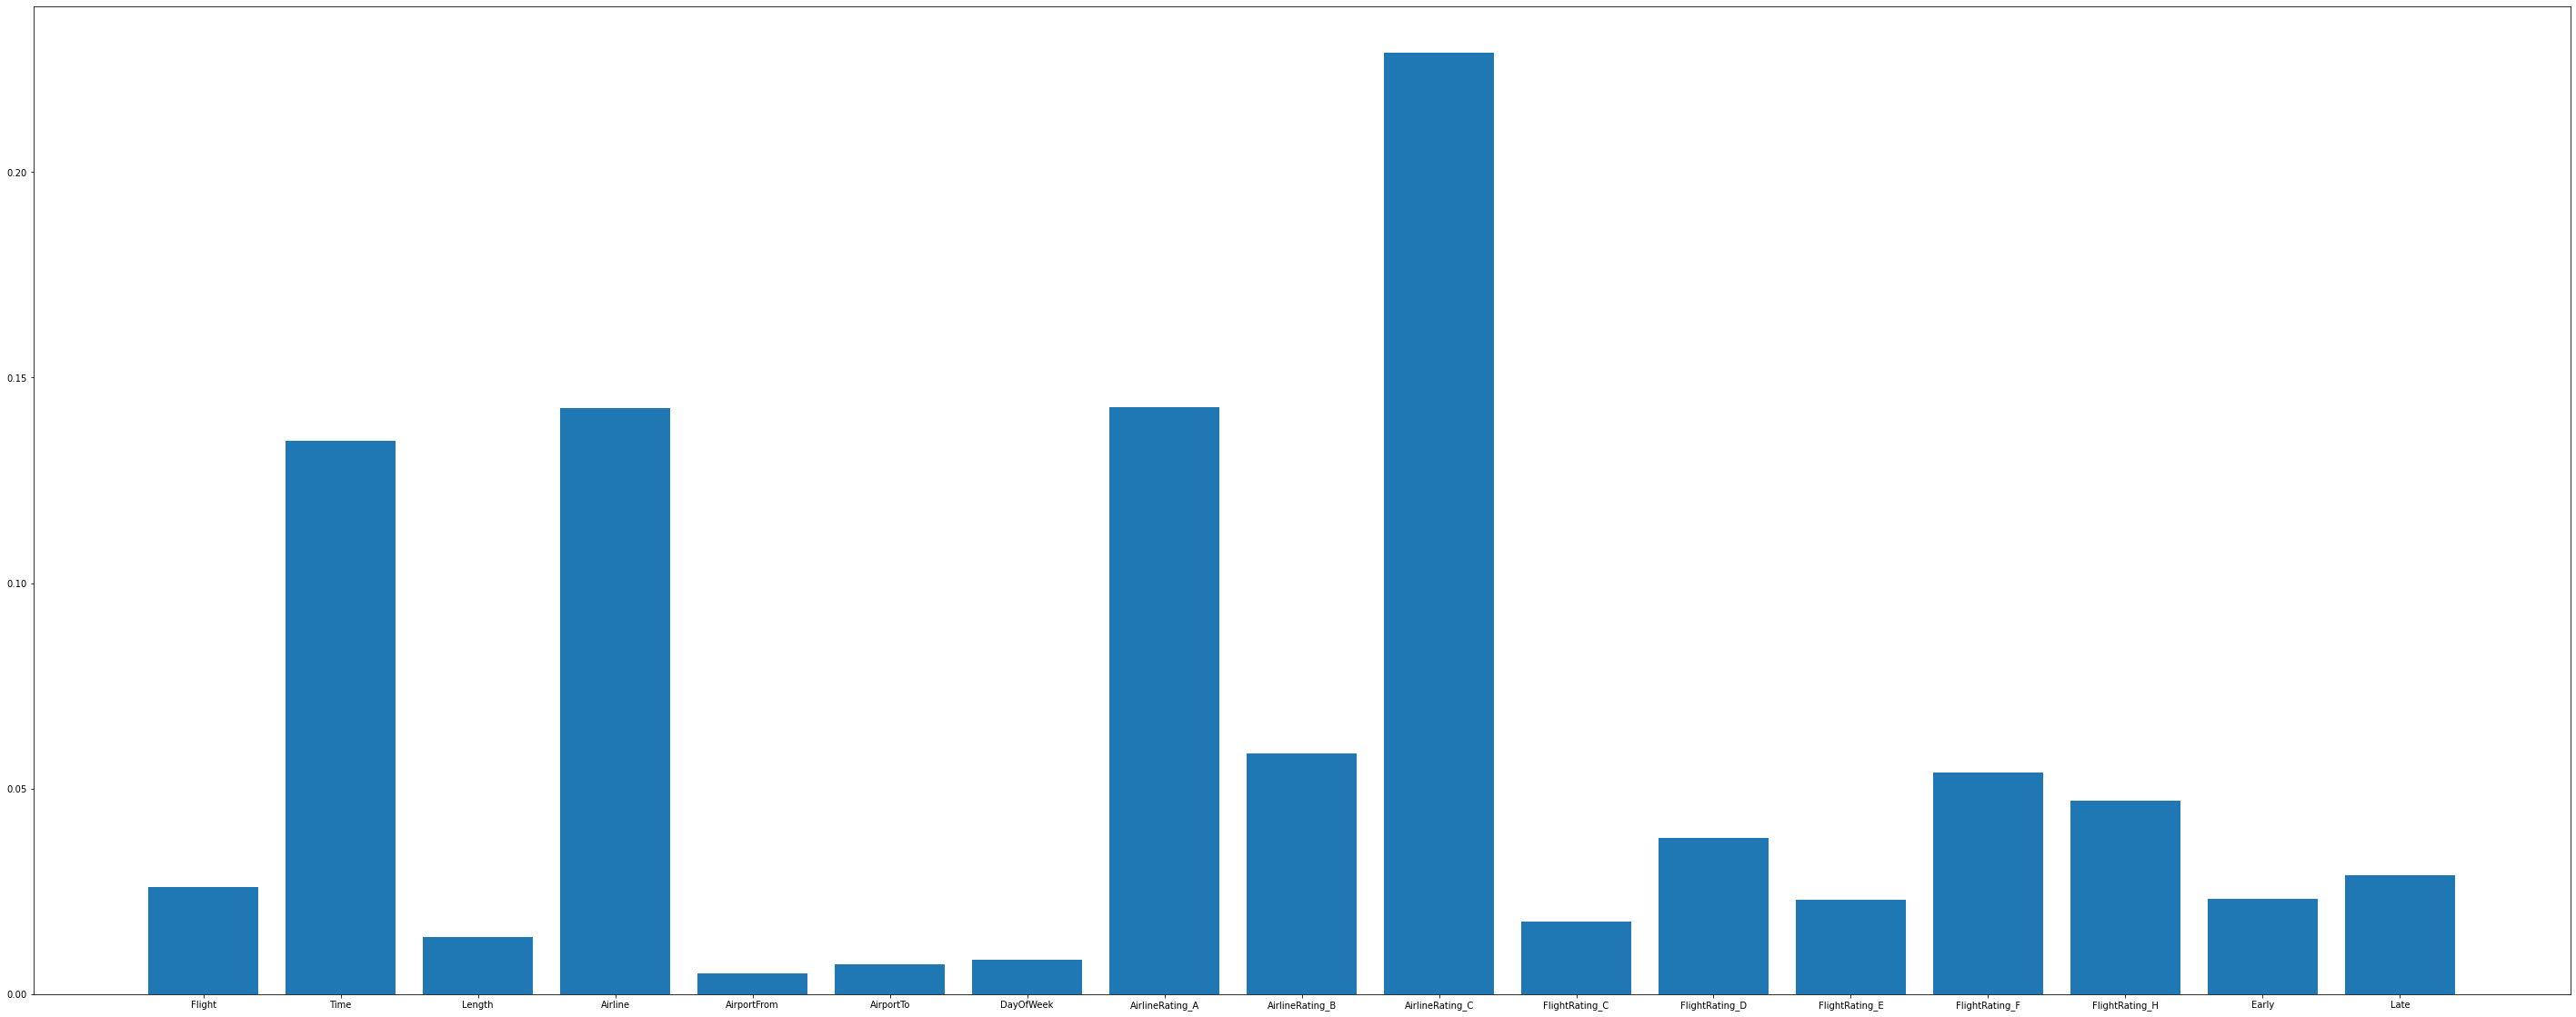

In [67]:
plt.figure(figsize = (50, 20))
plt.bar(X.columns, rf.feature_importances_);

Мы попробовали создавать новые признаки на основе дня недели и времени вылета по отдельности и это не привело к улучшению качества модели. Добавление признаков Early и Late увеличило precision на 0,01, что не очень значительно.

Попробуем сгенерировать новые признаки на основе времени вылета и дня недели одновременно. Для этого посмотрим на то, в какие дни недели и в какое время задержанных рейсов больше всего. Признаки Early и Late в этом случае возможно придётся удалить.

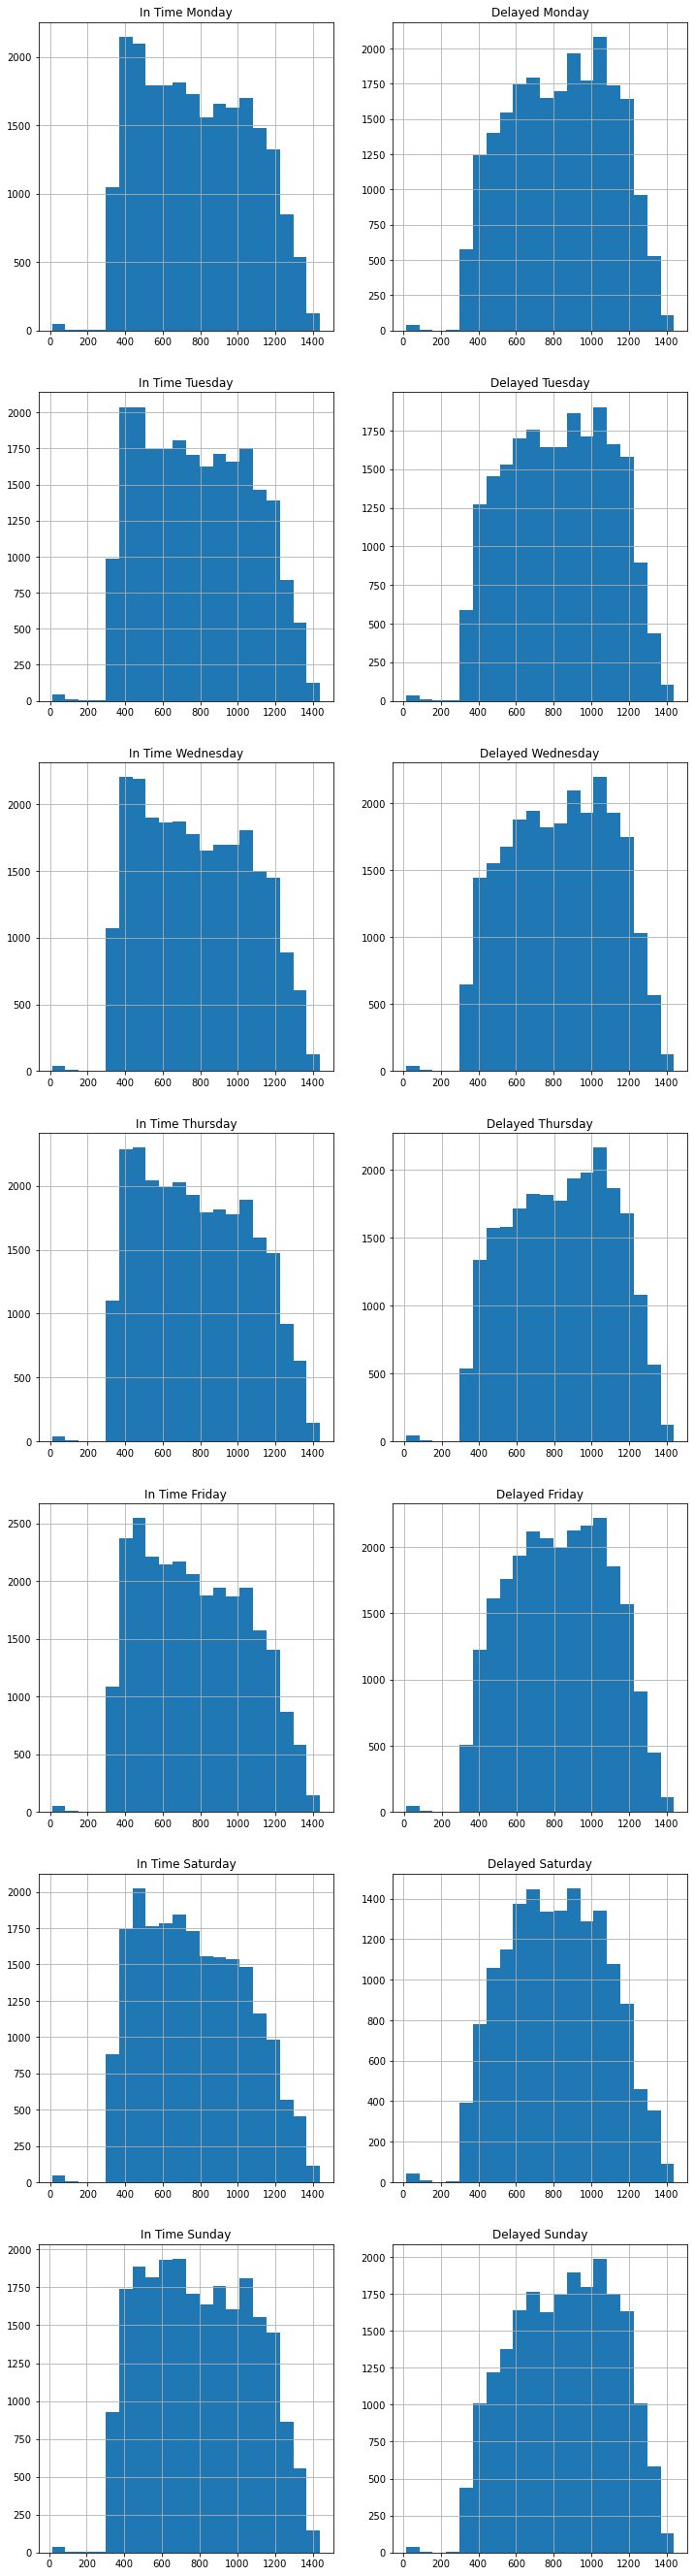

In [68]:
fig, axs = plt.subplots(figsize=(12, 48), ncols=2, nrows=7)

titles = [['In Time Monday', 'Delayed Monday'], ['In Time Tuesday', 'Delayed Tuesday'], 
         ['In Time Wednesday', 'Delayed Wednesday'], ['In Time Thursday', 'Delayed Thursday'],
         ['In Time Friday', 'Delayed Friday'], ['In Time Saturday', 'Delayed Saturday'], 
         ['In Time Sunday', 'Delayed Sunday']]

for i in range(1, 8):
    axs[i-1, 0].hist(df[df['DayOfWeek'] == i][df['Class'] == 0]['Time'], bins = 20)
    axs[i-1, 0].set_title(titles[i-1][0])
    axs[i-1, 0].grid()
    axs[i-1, 1].hist(df[df['DayOfWeek'] == i][df['Class'] == 1]['Time'], bins = 20)
    axs[i-1, 1].grid()
    axs[i-1, 1].set_title(titles[i-1][1]);

Можно заметить, что в разные дни недели наблюдается разный дисбаланс классов. Попробуем проанализировать в какие дни недели и в какое время суток наибольшая вероятность задержки рейса и создадим 3 новых признака (вероятность задержки менее 30%, от 30% до 60%, от 60%).

In [69]:
delayed_part_1 = {}

for i in df['DayOfWeek'].unique():
    delayed_part_2 = {}
    for j in df['Time'].unique():
        delayed_part_2[j] = df[df['DayOfWeek'] == i][df['Time'] == j]['Class'].mean()
    
    delayed_part_1[i] = delayed_part_2

In [70]:
for i in range (1, 7):
    print(len(delayed_part_1[i]) == len(delayed_part_1[i+1]))

True
True
True
True
True
True


In [71]:
ps_2 = {}

for i in delayed_part_1:
    ps_1 = {'30' : [], '60' : [], '100' : []}
    for j in delayed_part_1[i]:
        if delayed_part_1[i][j] < 0.3:
            ps_1['30'].append(j)
        elif (delayed_part_1[i][j] >= 0.3) and (delayed_part_1[i][j] < 0.6):
            ps_1['60'].append(j)
        else:
            ps_1['100'].append(j)
    ps_2[i] = ps_1

In [72]:
df_2 = 0

for i in ps_2:
    df_boofer = df_1[df_1['DayOfWeek'] == i]
    df_boofer['Before_30'] = np.where(df_boofer['Time'].isin(ps_2[i]['30']), 1, 0)
    df_boofer['From_30_To_60'] = np.where(df_boofer['Time'].isin(ps_2[i]['60']), 1, 0)
    df_boofer['From_60_To_100'] = np.where(df_boofer['Time'].isin(ps_2[i]['100']), 1, 0)
    if type(df_2) == int:
        df_2 = df_boofer.copy()
    else:
        df_2 = pd.concat([df_2, df_boofer])  

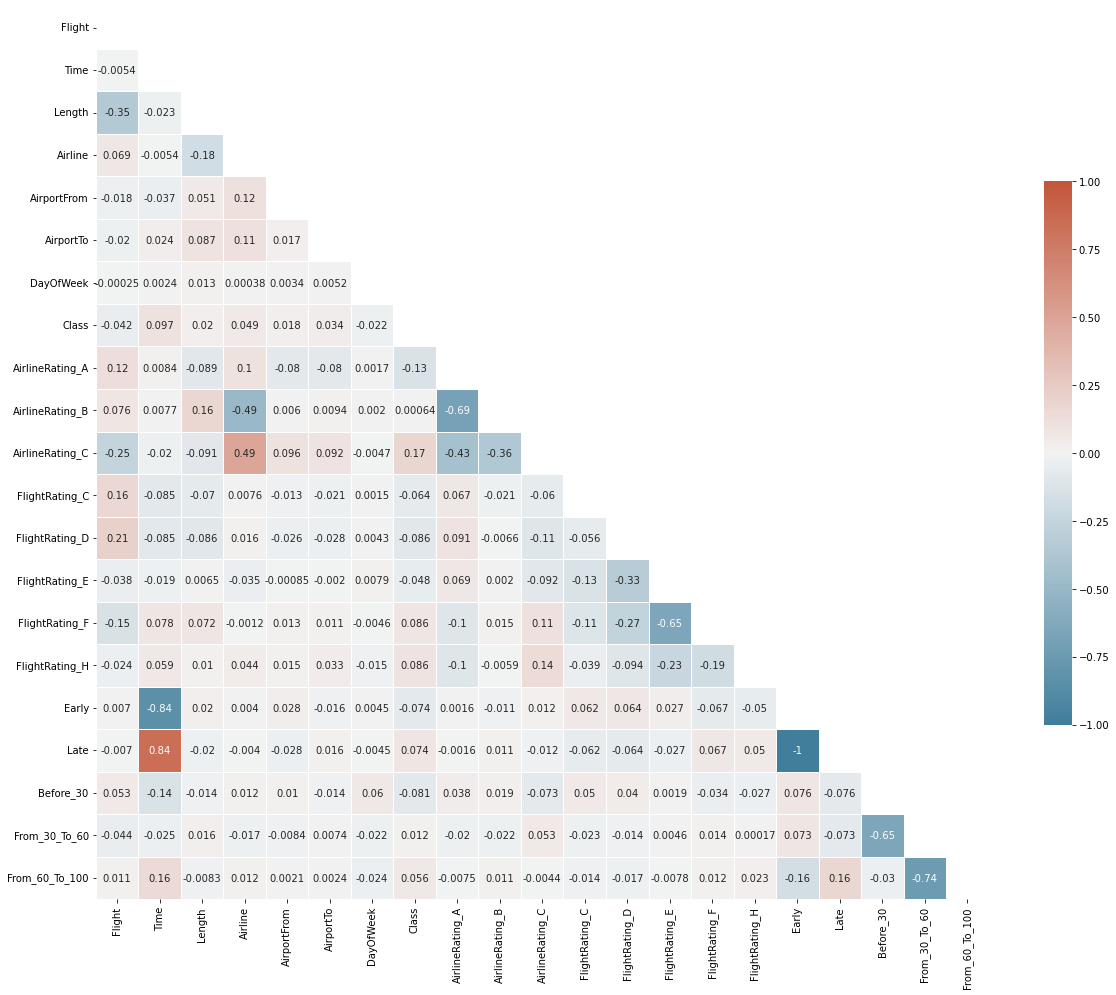

In [73]:
corr = df_2.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           );

In [74]:
df_2 = df_2.drop(['Early', 'Late'], axis = 1)

In [75]:
X = df_2.drop(['Class'], axis = 1)
y = df_2['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

object = StandardScaler() 
X_train.iloc[:, [1, 2]] = object.fit_transform(X_train.iloc[:, [1, 2]])

X_test.iloc[:, [1, 2]] = object.transform(X_test.iloc[:, [1, 2]])

rf = RandomForestClassifier(n_estimators = 54, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.6
precision = 0.42
recall = 0.62
roc_auc = 0.6
f1 = 0.5


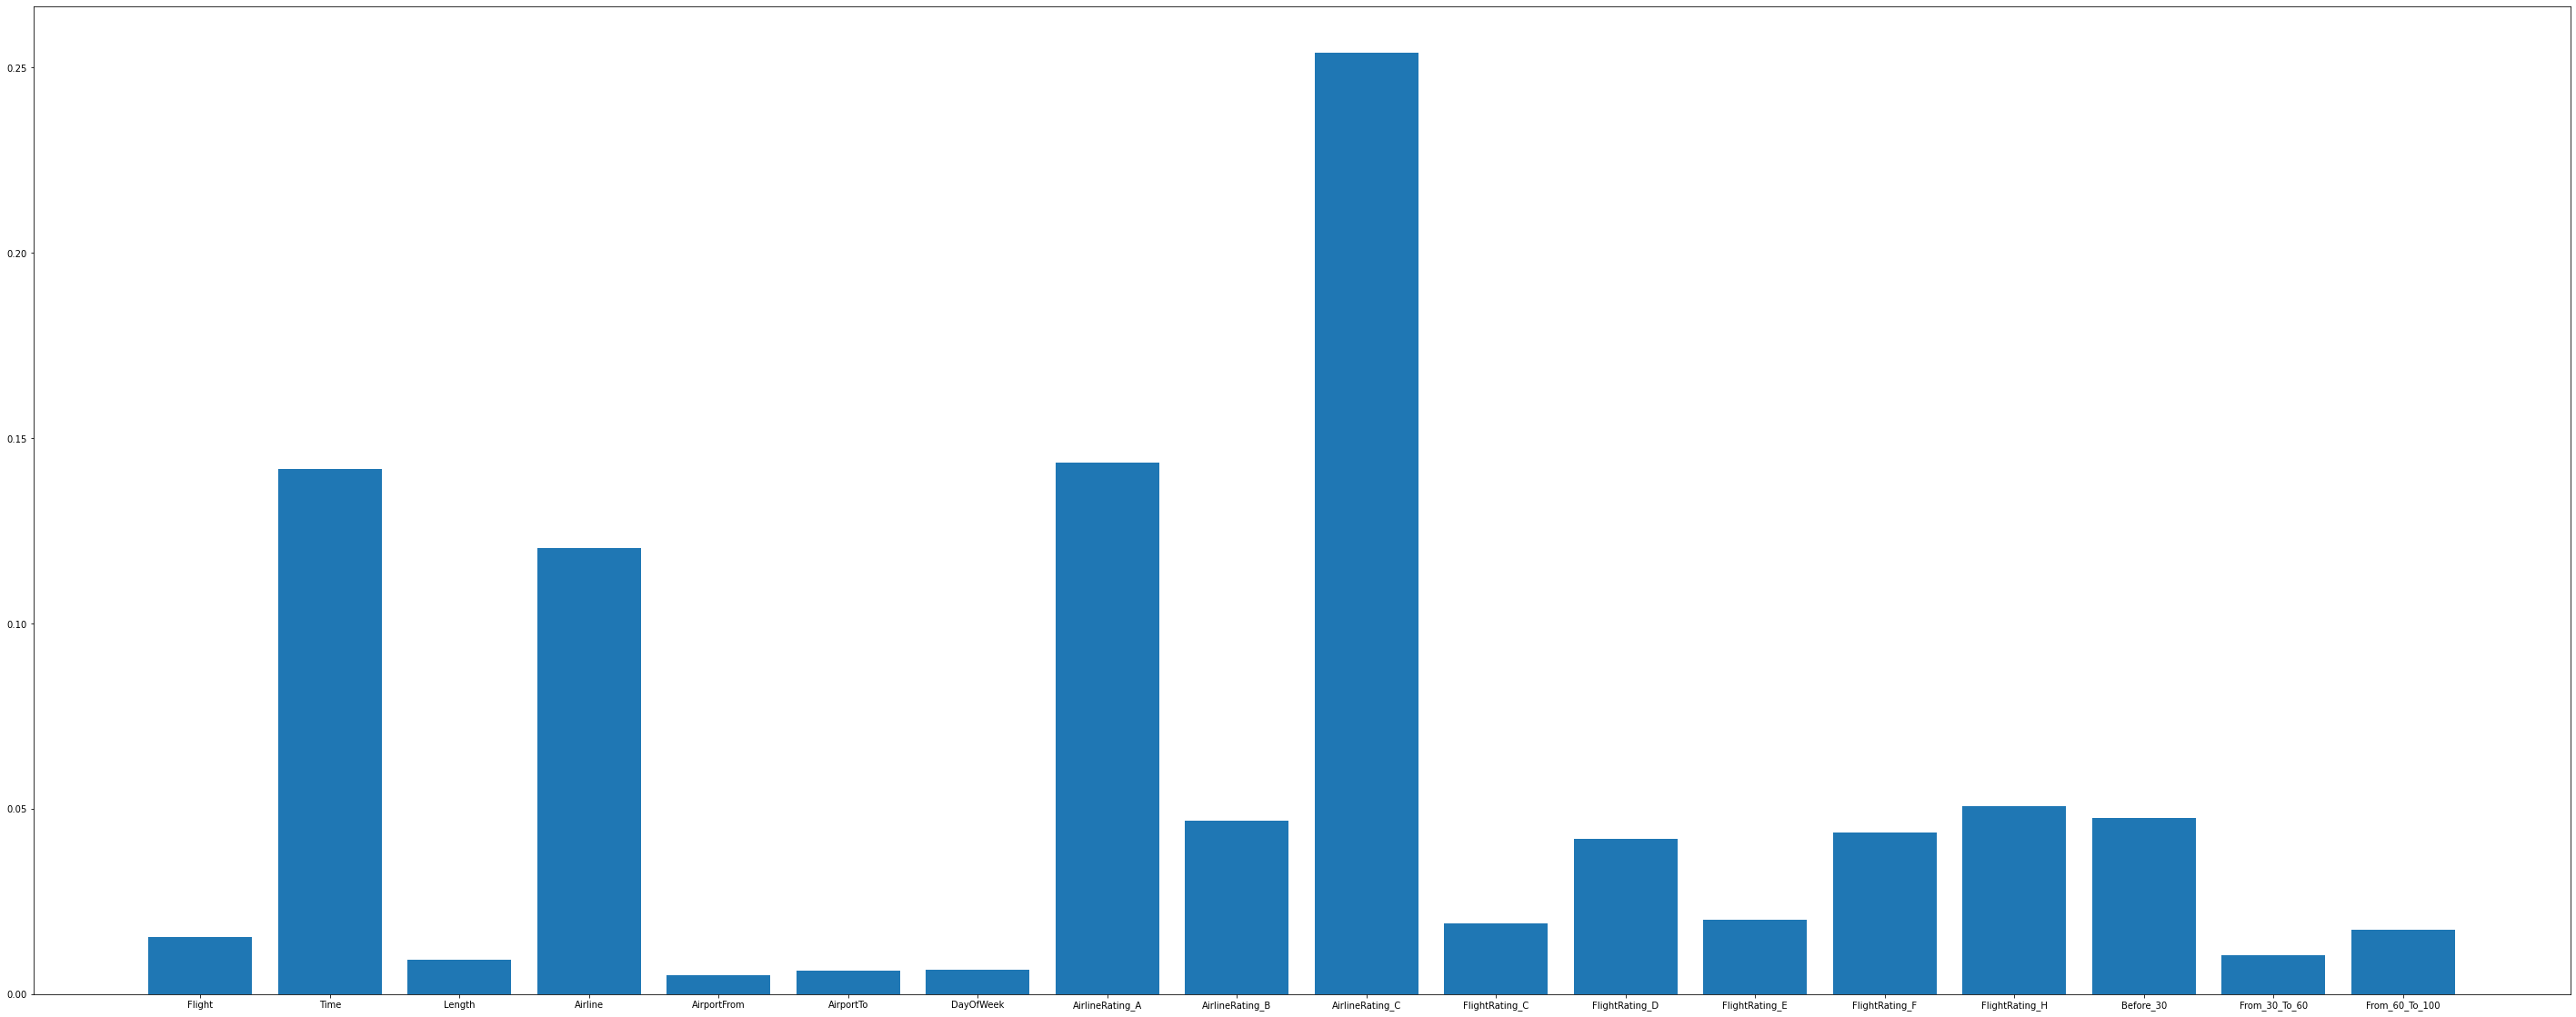

In [76]:
plt.figure(figsize = (50, 20))
plt.bar(X.columns, rf.feature_importances_);

Метрика precision немного выросла, но доля правильных ответов по прежнему 0.6. Поробуем смешать модель случайного леса с алгоритмом, у которого значение метрици precision сильно выше, например с SGD или SVC. Перед этим заново подберем по сетке гиперпараметры.

In [156]:
rf = RandomForestClassifier(n_estimators = 50, n_jobs = 4, random_state = 20)

param_grid = [
    {
        'max_depth':[i for i in range(1, 7)],
        'n_estimators': [i for i in range(1,100)]
    }]

grid = GridSearchCV(rf, param_grid, n_jobs = 4, cv=5, scoring='f1', return_train_score=True)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=4,
                                              random_state=20),
             n_jobs=4,
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6],
                          'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14, 15, 16, 17, 18, 19, 20,
                                           21, 22, 23, 24, 25, 26, 27, 28, 29,
                                           30, ...]}],
             return_train_score=True, scoring='f1')

In [157]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.6258969675854832
{'max_depth': 2, 'n_estimators': 1}
RandomForestClassifier(max_depth=2, n_estimators=1, n_jobs=4, random_state=20)


In [158]:
rf = RandomForestClassifier(n_estimators = 1, max_depth = 2, n_jobs = 4, random_state = 20)

param_grid = [
    {
        'min_samples_split': [i for i in range(1,100)]
    }]

grid = GridSearchCV(rf, param_grid, n_jobs = 4, cv=5, scoring='f1', return_train_score=True)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=2, n_estimators=1,
                                              n_jobs=4, random_state=20),
             n_jobs=4,
             param_grid=[{'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                11, 12, 13, 14, 15, 16, 17, 18,
                                                19, 20, 21, 22, 23, 24, 25, 26,
                                                27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='f1')

In [159]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.6258969675854832
{'min_samples_split': 2}
RandomForestClassifier(max_depth=2, n_estimators=1, n_jobs=4, random_state=20)


In [161]:
svc = LinearSVC()
C = range(1,50)

param_grid = dict(C=C)
grid = GridSearchCV(svc, param_grid, cv=5, n_jobs = -1, scoring='f1', return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': range(1, 50)}, return_train_score=True,
             scoring='f1')

In [162]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.6089654282989432
{'C': 35}
LinearSVC(C=35)


In [163]:
sgd = SGDClassifier()

losses = ["hinge", "modified_huber", "log"]
penalties = ['l2', 'l1', 'elasticnet', None]

sgd = SGDClassifier()
param_grid = dict(loss=losses, penalty = penalties)

grid = GridSearchCV(sgd, param_grid, cv=5, n_jobs = -1, scoring='f1', return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'loss': ['hinge', 'modified_huber', 'log'],
                         'penalty': ['l2', 'l1', 'elasticnet', None]},
             return_train_score=True, scoring='f1')

In [164]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.6287098610424346
{'loss': 'modified_huber', 'penalty': None}
SGDClassifier(loss='modified_huber', penalty=None)


In [165]:
def est_pred(X_train, y_train, X_test, y_test, a):
    sgd = SGDClassifier(loss = 'modified_huber', penalty = None, random_state = 20)
    rf = RandomForestClassifier(n_estimators = 1, max_depth = 2, min_samples_split = 2, random_state = 20)
    
    sgd.fit(X_train, y_train)
    y_predicted_1 = sgd.predict(X_test)
    
    rf.fit(X_train, y_train)
    y_predicted_2 = rf.predict(X_test)
    
    res = np.round(y_predicted_1 * a + y_predicted_2 * (1 - a)).astype(int)
    
    return accuracy_score(y_test, res), precision_score(y_test, res), recall_score(y_test, res), res

In [166]:
ac_max = 0
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    accuracy, precision, recall, y_pred = est_pred(X_train, y_train, X_test, y_test, i)
    if accuracy > ac_max:
        ac_max = accuracy
        pr = precision
        rec = recall
        y_pred_best = y_pred
        a = i

print(f'a = {a}\naccuracy = {round(ac_max, 2)}\nprecision = {round(pr, 2)}\n\
recall = {round(rec, 2)}\n')

a = 0.6
accuracy = 0.59
precision = 0.6
recall = 0.45



In [167]:
round(f1_score(y_pred_best, y_test), 2)

0.51

In [168]:
round(roc_auc_score(y_pred_best, y_test), 2)

0.59

Метрика precision выросла, но при этом упала метрика recall. Доля правильных ответов стала меньше. Попробуем смешать решающий лес с SVC.

In [169]:
def est_pred_1(X_train, y_train, X_test, y_test, a):
    svc = LinearSVC(C=35)
    rf = RandomForestClassifier(n_estimators = 1, max_depth = 2, min_samples_split = 2, random_state = 20)
    
    svc.fit(X_train, y_train)
    y_predicted_1 = svc.predict(X_test)
    
    rf.fit(X_train, y_train)
    y_predicted_2 = rf.predict(X_test)
    
    res = np.round(y_predicted_1 * a + y_predicted_2 * (1 - a)).astype(int)
    
    return accuracy_score(y_test, res), precision_score(y_test, res), recall_score(y_test, res), res

In [170]:
ac_max = 0
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    accuracy, precision, recall, y_pred = est_pred_1(X_train, y_train, X_test, y_test, i)
    if accuracy > ac_max:
        ac_max = accuracy
        pr = precision
        rec = recall
        y_pred_best = y_pred
        a = i

print(f'a = {a}\naccuracy = {round(ac_max, 2)}\nprecision = {round(pr, 2)}\n\
recall = {round(rec, 2)}\n')

a = 0.5
accuracy = 0.55
precision = 0.56
recall = 0.32



In [171]:
round(f1_score(y_pred_best, y_test), 2)

0.41

In [172]:
round(roc_auc_score(y_pred_best, y_test), 2)

0.55

Метрика precision выросла, но при этом упала метрика recall и доля правильных ответов стала меньше.

Ни 1 из примененных алгоритмов классификации не дал удовлетворительного результата, в том числе и ансамблевые.

Попробуем в корне другой подход. Мы знаем, что все признаки очень слабо коррелируют с целевой переменной, при этом генерация новых признаков на основе Airline, Flight, DayOfWeek и Time дало улучшение качества модели, хоть и незначительное. Новые признаки были основаны на системе рейтингов. Попробуем сгенерировать для каждого из этого признаков новые, которые будут указывать долю задержанных рейсов (например доля задержанных рейсов для дня недели №1, доля задержанных рейсов для авиакомпании с кодом 5 и т.д.). Возможно в этом случае мы получим признаки, которые лучше коррелируют с целевой переменной.

In [80]:
df

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313,1296.0,141.0,5,16,129,1,0
1,6948,360.0,146.0,12,65,208,4,0
2,1247,1170.0,143.0,3,35,60,3,0
3,31,1410.0,344.0,14,203,217,6,0
4,563,692.0,98.0,8,32,16,4,0
...,...,...,...,...,...,...,...,...
539371,2280,1170.0,86.0,16,135,223,1,1
539373,865,1240.0,154.0,14,216,173,7,1
539375,769,480.0,287.0,4,153,96,2,1
539377,6973,530.0,72.0,12,111,252,5,1


In [37]:
# доли задержанных рейсов для номеров рейсов

delayed_part = {}

for i in df['Flight'].unique():
    delayed_part[i] = df[df['Flight'] == i]['Class'].mean()

In [38]:
len(delayed_part) == len(df['Flight'].unique())

True

In [39]:
df_3 = df.copy()
df_3['Flight_Delays_Part'] = 0

for i in df_3['Flight'].unique():
    df_3['Boofer'] = np.where(df_3['Flight'] == i, delayed_part[i], 0)
    df_3['Flight_Delays_Part'] = df_3['Flight_Delays_Part'] + df_3['Boofer']

df_3 = df_3.drop('Boofer', axis = 1)

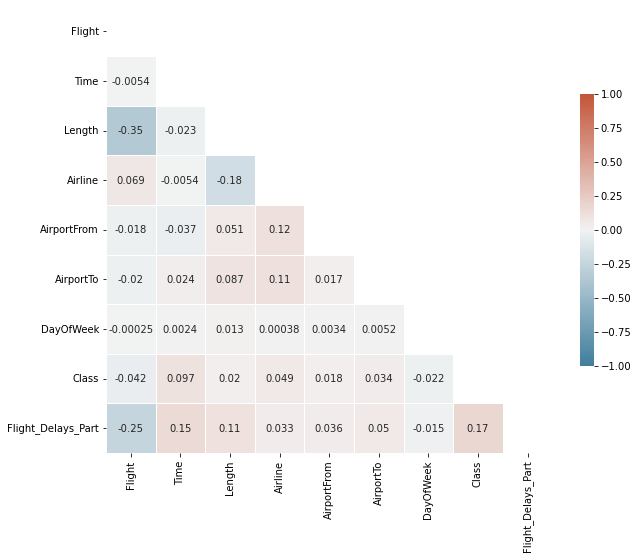

In [40]:
corr = df_3.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           );

Мы видим, что переменная Flight_Delays_Part коррелирует с целевой переменной сильнее, чем любой из исходных признаков. При этом сам признак Flight коррелирует с целевой переменной сильно слабее. Попробуем выполнить то же самое для других признаков и построить модель на основе алгоритма случайного леса.

In [41]:
delayed_part = {}

for i in df['Time'].unique():
    delayed_part[i] = df[df['Time'] == i]['Class'].mean()

df_3['Time_Delays_Part'] = 0

for i in df_3['Time'].unique():
    df_3['Boofer'] = np.where(df_3['Time'] == i, delayed_part[i], 0)
    df_3['Time_Delays_Part'] = df_3['Time_Delays_Part'] + df_3['Boofer']

df_3 = df_3.drop('Boofer', axis = 1)

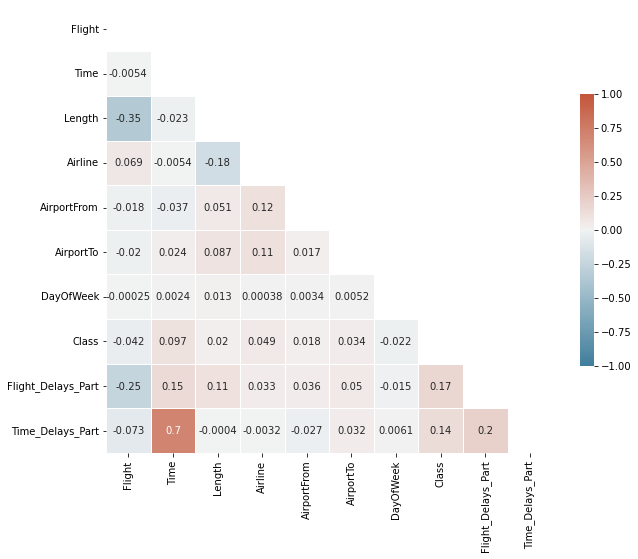

In [42]:
corr = df_3.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           );

In [43]:
delayed_part = {}

for i in df['Length'].unique():
    delayed_part[i] = df[df['Length'] == i]['Class'].mean()

df_3['Length_Delays_Part'] = 0

for i in df_3['Length'].unique():
    df_3['Boofer'] = np.where(df_3['Length'] == i, delayed_part[i], 0)
    df_3['Length_Delays_Part'] = df_3['Length_Delays_Part'] + df_3['Boofer']

df_3 = df_3.drop('Boofer', axis = 1)

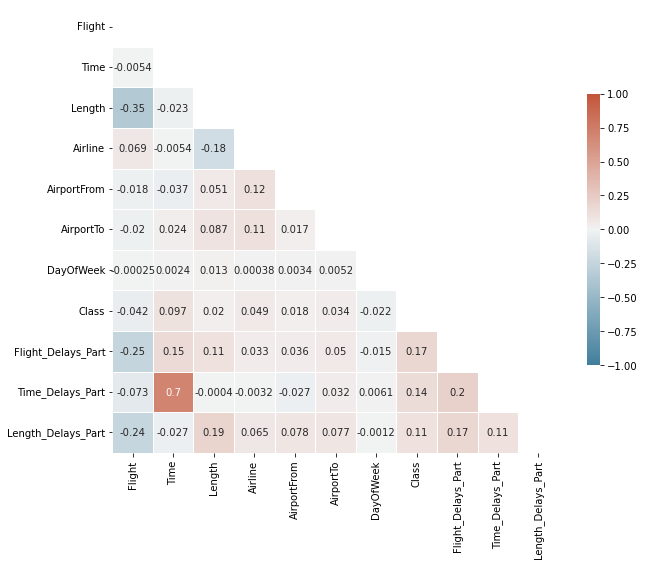

In [44]:
corr = df_3.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           );

Можно заметить, что новые сгенерированные признаки коррелируют с целевой переменной сильнее, чем исходные. Сгенерируем новые признаки на основе всех имеющихся старых. При этом стоит обратить внимание, что в некоторых случаях новые признаки немного коррелируют со старыми, на основе которых они были сгенерированы. Возможно в перспективе придется избавиться от ряда признаков.

In [45]:
delayed_part = {}

for i in df['Airline'].unique():
    delayed_part[i] = df[df['Airline'] == i]['Class'].mean()

df_3['Airline_Delays_Part'] = 0

for i in df_3['Airline'].unique():
    df_3['Boofer'] = np.where(df_3['Airline'] == i, delayed_part[i], 0)
    df_3['Airline_Delays_Part'] = df_3['Airline_Delays_Part'] + df_3['Boofer']

df_3 = df_3.drop('Boofer', axis = 1)

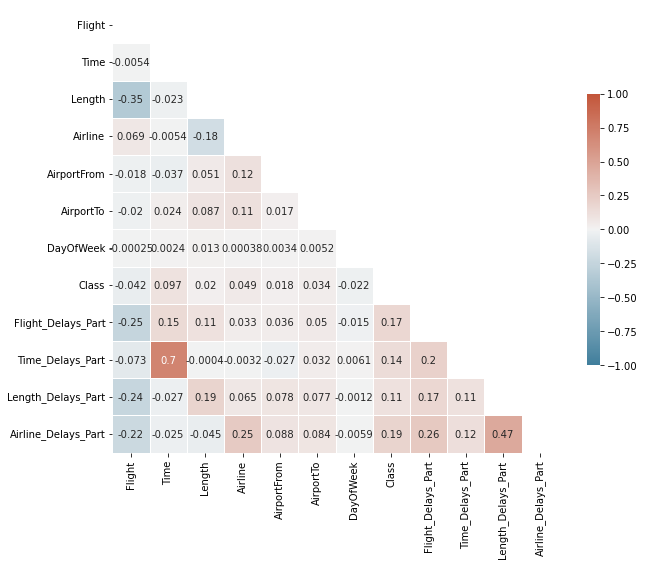

In [46]:
corr = df_3.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           );

In [47]:
delayed_part = {}

for i in df['AirportTo'].unique():
    delayed_part[i] = df[df['AirportTo'] == i]['Class'].mean()

df_3['AirportTo_Delays_Part'] = 0

for i in df_3['AirportTo'].unique():
    df_3['Boofer'] = np.where(df_3['AirportTo'] == i, delayed_part[i], 0)
    df_3['AirportTo_Delays_Part'] = df_3['AirportTo_Delays_Part'] + df_3['Boofer']

df_3 = df_3.drop('Boofer', axis = 1)

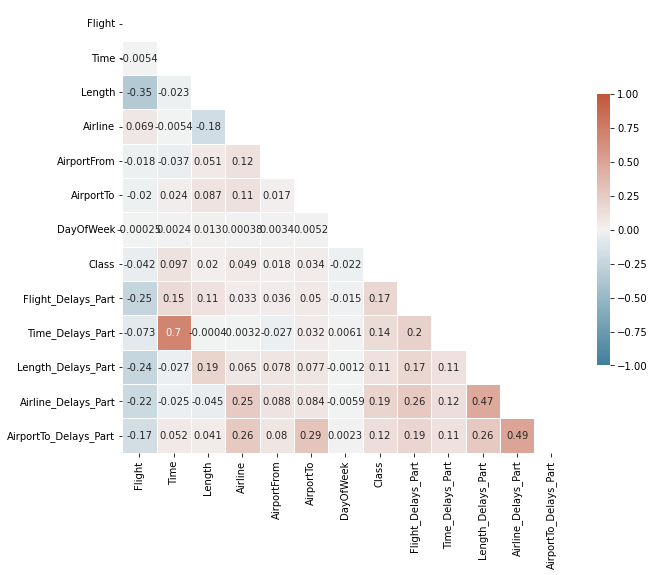

In [48]:
corr = df_3.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           );

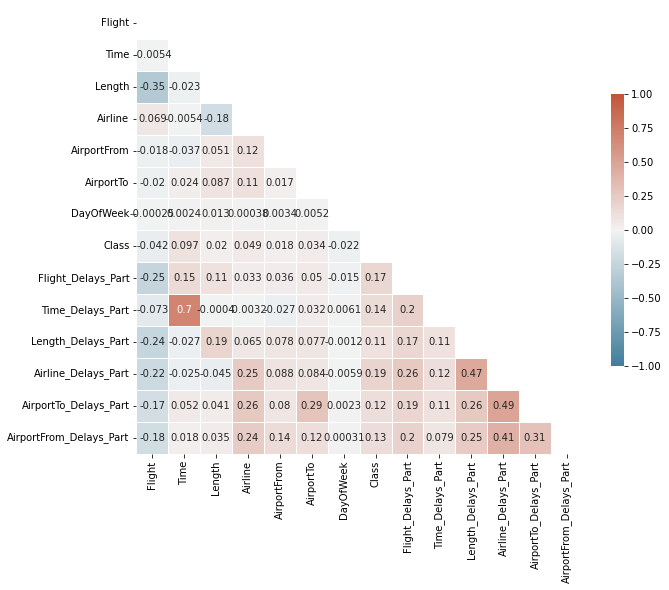

In [49]:
delayed_part = {}

for i in df['AirportFrom'].unique():
    delayed_part[i] = df[df['AirportFrom'] == i]['Class'].mean()

df_3['AirportFrom_Delays_Part'] = 0

for i in df_3['AirportFrom'].unique():
    df_3['Boofer'] = np.where(df_3['AirportFrom'] == i, delayed_part[i], 0)
    df_3['AirportFrom_Delays_Part'] = df_3['AirportFrom_Delays_Part'] + df_3['Boofer']

df_3 = df_3.drop('Boofer', axis = 1)

corr = df_3.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           );

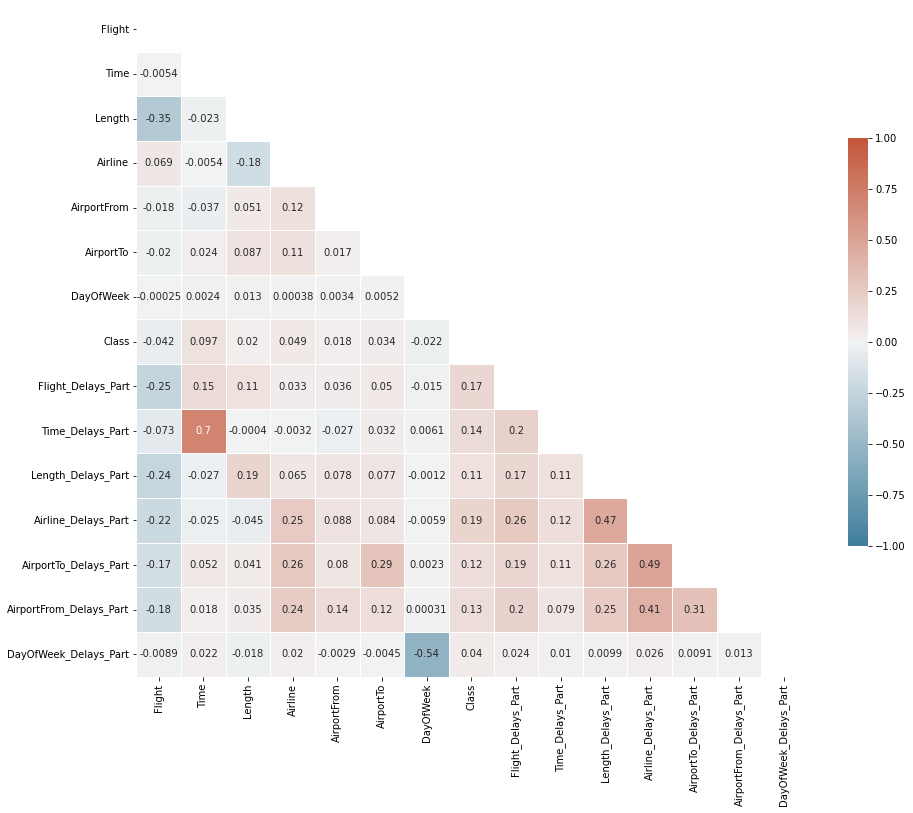

In [50]:
delayed_part = {}

for i in df['DayOfWeek'].unique():
    delayed_part[i] = df[df['DayOfWeek'] == i]['Class'].mean()

df_3['DayOfWeek_Delays_Part'] = 0

for i in df_3['DayOfWeek'].unique():
    df_3['Boofer'] = np.where(df_3['DayOfWeek'] == i, delayed_part[i], 0)
    df_3['DayOfWeek_Delays_Part'] = df_3['DayOfWeek_Delays_Part'] + df_3['Boofer']

df_3 = df_3.drop('Boofer', axis = 1)

corr = df_3.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(15, 15))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           );

In [51]:
X = df_3.drop(['Class'], axis = 1)
y = df_3['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

object = StandardScaler() 
X_train.iloc[:, [1, 2]] = object.fit_transform(X_train.iloc[:, [1, 2]])

X_test.iloc[:, [1, 2]] = object.transform(X_test.iloc[:, [1, 2]])

rf = RandomForestClassifier(n_estimators = 54, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.6
precision = 0.41
recall = 0.63
roc_auc = 0.61
f1 = 0.5


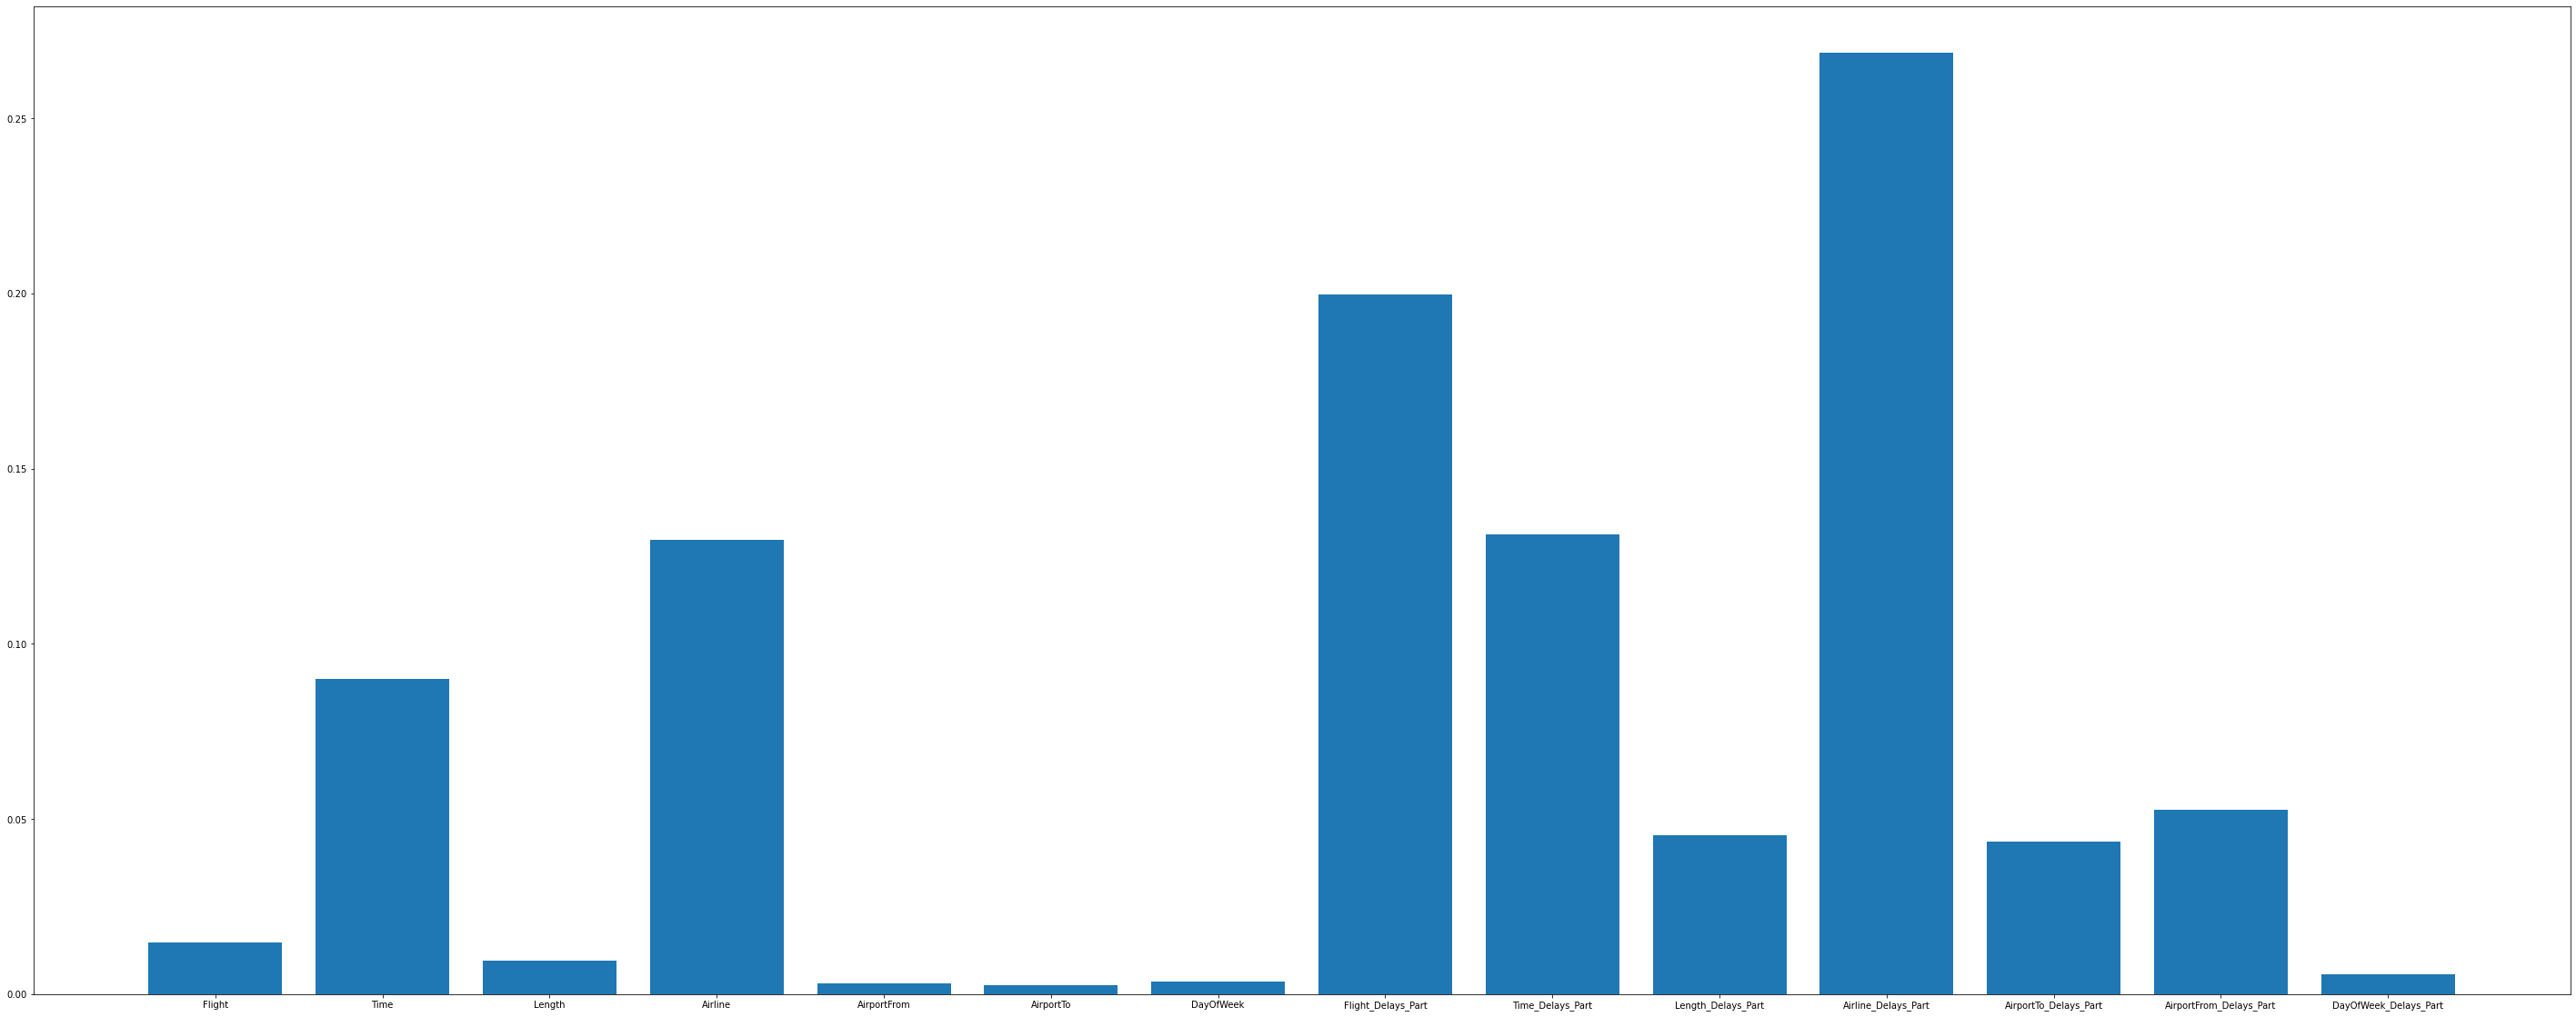

In [52]:
plt.figure(figsize = (50, 20))
plt.bar(X.columns, rf.feature_importances_);

Попробуем убрать незначимые признаки.

In [53]:
X = df_3.drop(['Class', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Length', 'Time', 'Airline', 'Flight'], axis = 1)
y = df_3['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

object = StandardScaler() 
X_train.iloc[:, [1, 2]] = object.fit_transform(X_train.iloc[:, [1, 2]])

X_test.iloc[:, [1, 2]] = object.transform(X_test.iloc[:, [1, 2]])

rf = RandomForestClassifier(n_estimators = 54, max_depth = 6, min_samples_split = 19, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.6
precision = 0.43
recall = 0.62
roc_auc = 0.61
f1 = 0.51


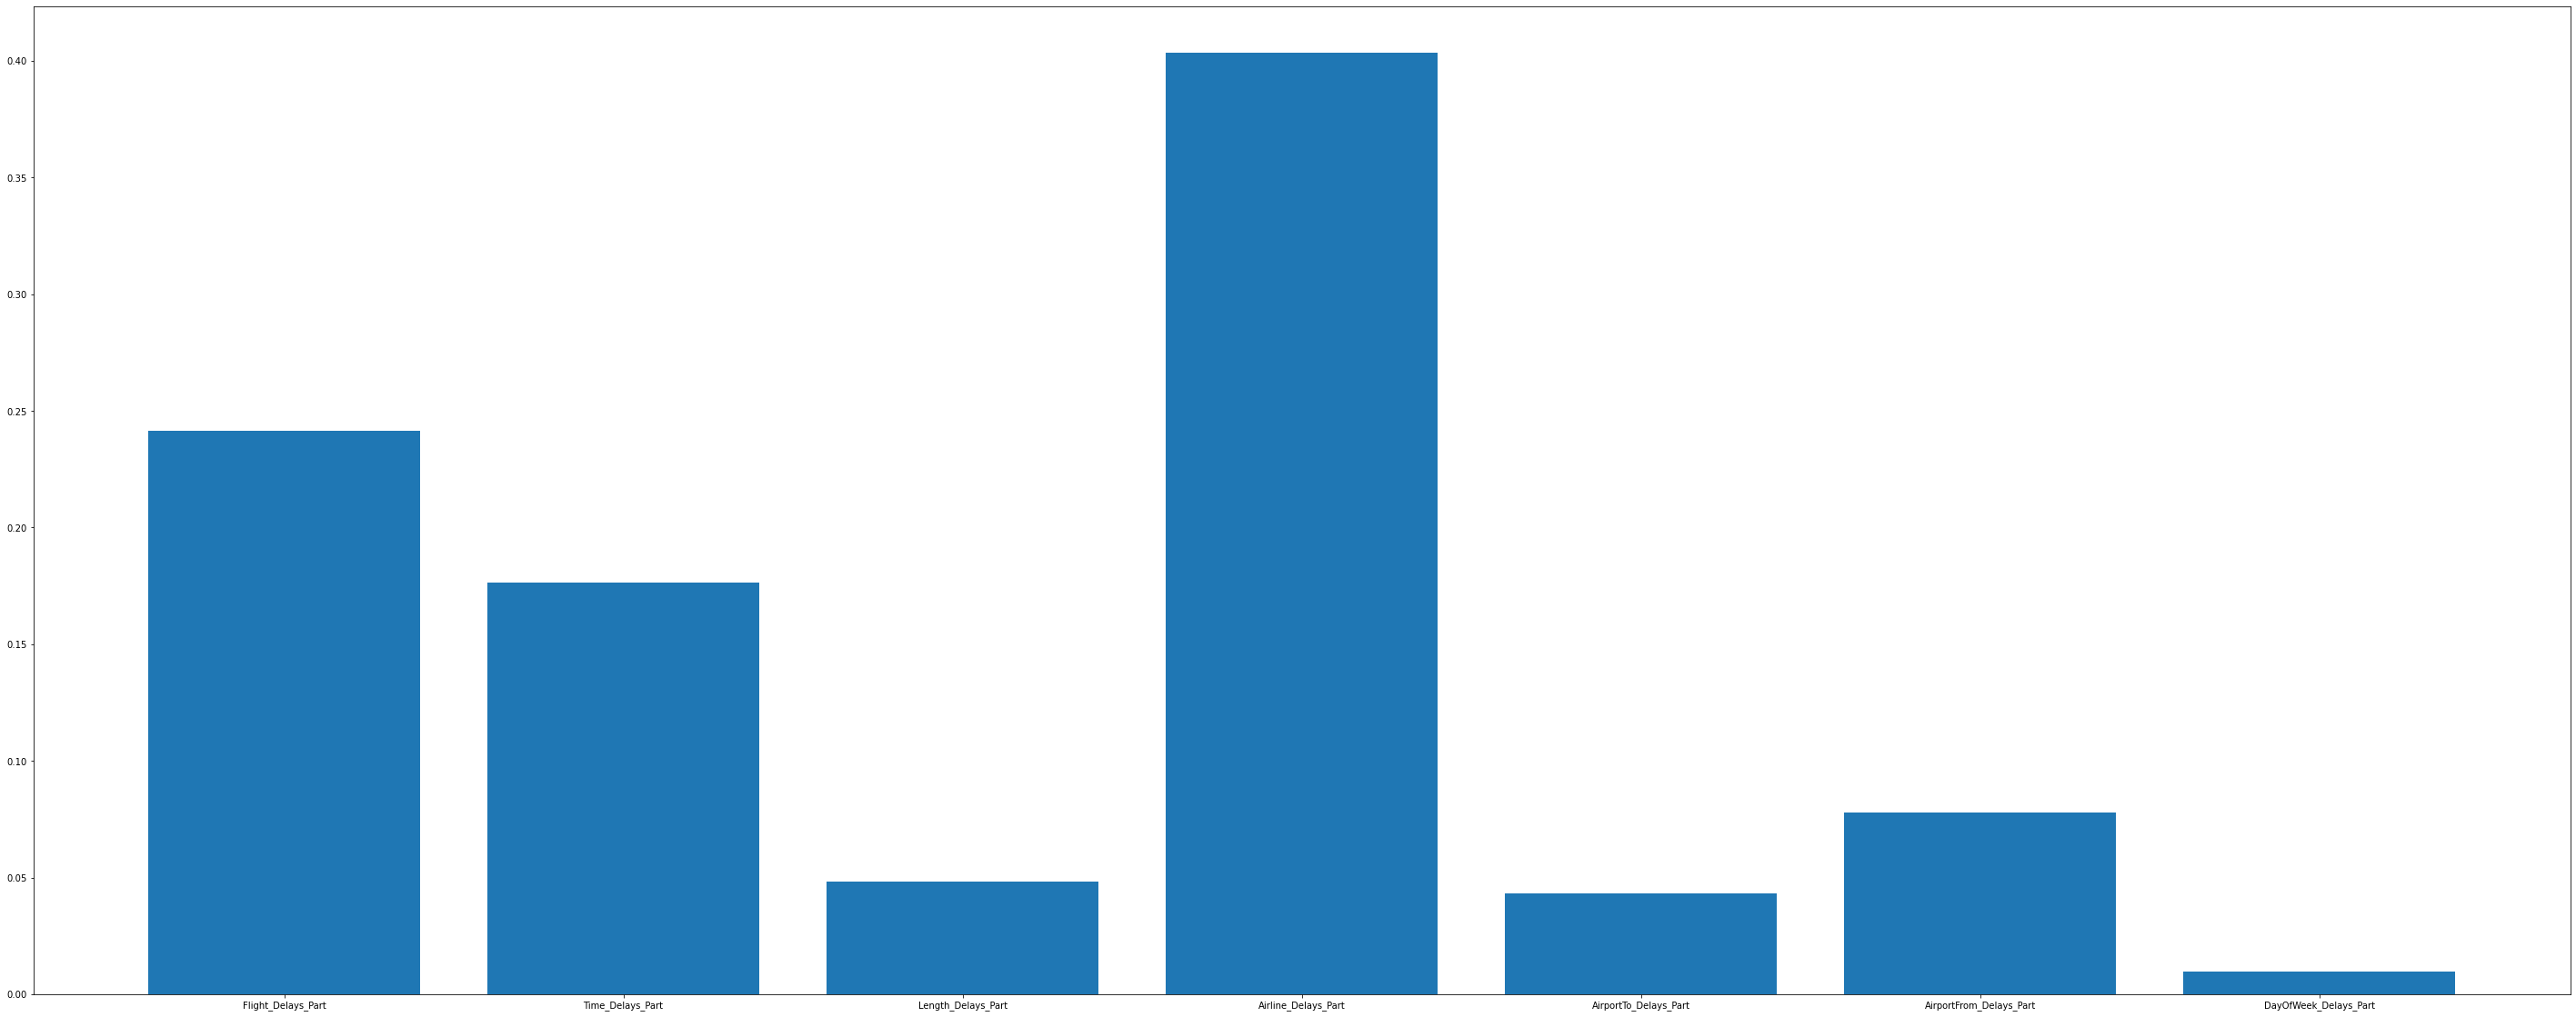

In [54]:
plt.figure(figsize = (50, 20))
plt.bar(X.columns, rf.feature_importances_);

Видим, что при тех же значениях гиперпараметров качество модели стало чуть-чуть лучше. Выполним подбор гиперпараметров по сетке.

In [158]:
rf = RandomForestClassifier(n_estimators = 50, n_jobs = -1, random_state = 20)

param_grid = [
    {
        'max_depth':[i for i in range(1, 7)],
        'n_estimators': [i for i in range(1, 70)]
    }]

grid = GridSearchCV(rf, param_grid, n_jobs = -1, cv=5, scoring='roc_auc', return_train_score=True)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                              random_state=20),
             n_jobs=-1,
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6],
                          'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14, 15, 16, 17, 18, 19, 20,
                                           21, 22, 23, 24, 25, 26, 27, 28, 29,
                                           30, ...]}],
             return_train_score=True, scoring='roc_auc')

In [159]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.6404169301293713
{'max_depth': 6, 'n_estimators': 68}
RandomForestClassifier(max_depth=6, n_estimators=68, n_jobs=-1, random_state=20)


In [55]:
rf = RandomForestClassifier(n_estimators = 68, max_depth = 6, n_jobs = -1, random_state = 20)

param_grid = [
    {
        'min_samples_split': [i for i in range(1,100)]
    }]

grid = GridSearchCV(rf, param_grid, n_jobs = -1, cv=5, scoring='roc_auc', return_train_score=True)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=6, n_estimators=68,
                                              n_jobs=-1, random_state=20),
             n_jobs=-1,
             param_grid=[{'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                11, 12, 13, 14, 15, 16, 17, 18,
                                                19, 20, 21, 22, 23, 24, 25, 26,
                                                27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='roc_auc')

In [56]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.640469008308181
{'min_samples_split': 29}
RandomForestClassifier(max_depth=6, min_samples_split=29, n_estimators=68,
                       n_jobs=-1, random_state=20)


In [57]:
rf = RandomForestClassifier(n_estimators = 68, max_depth = 6, min_samples_split = 29, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.6
precision = 0.43
recall = 0.62
roc_auc = 0.61
f1 = 0.51


#### XGBoost

Генерация новых признаков и подбор гиперпараметров по сетке позволило немного улучшить модель, но глобально качество не изменилось. Попробуем алгоритм градиентного бустинга.

In [61]:
import xgboost as xgb

In [62]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.6
precision = 0.48
recall = 0.6
roc_auc = 0.6
f1 = 0.53


Градиентный бустинг "из коробки" не дал улучшения. Возможно при подборе гиперпараметров по сетке результаты улучшатся.

In [64]:
clf = xgb.XGBClassifier(learning_rate=0.1,
                          n_estimators=150,
                          objective= 'binary:logistic',
                          nthread=-1,
                          scale_pos_weight=1,
                          seed=27)

In [65]:
param_test1 = {
    'max_depth':range(2,7,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator=clf, 
                        param_grid=param_test1,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch1.fit(X_train, y_train)

gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 4, 'min_child_weight': 1}, 0.6451672286773856)

In [66]:
param_test2 = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [2, 3, 4]
}

gsearch2 = GridSearchCV(estimator=clf, 
                        param_grid=param_test2,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch2.fit(X_train, y_train)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 4, 'min_child_weight': 2}, 0.6451350497198043)

In [68]:
clf = xgb.XGBClassifier(learning_rate=0.1,
                          n_estimators=150,
                          objective= 'binary:logistic', max_depth = 4, min_child_weight = 2,
                          nthread=-1,
                          scale_pos_weight=1,
                          seed=27)


param_test3 = {
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

gsearch3b = GridSearchCV(estimator=clf, 
                        param_grid=param_test3,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch3b.fit(X_train, y_train)
gsearch3b.best_params_, gsearch3b.best_score_

({'gamma': 0.2}, 0.6451893107974318)

In [69]:
clf = xgb.XGBClassifier(learning_rate=0.1,
                          n_estimators=150,
                          objective= 'binary:logistic', max_depth = 4, min_child_weight = 2, gamma = 0.2,
                          nthread=-1,
                          scale_pos_weight=1,
                          seed=27)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f'accuracy = {round(accuracy, 2)}\nprecision = {round(precision, 2)}\n\
recall = {round(recall, 2)}\nroc_auc = {round(roc_auc, 2)}\nf1 = {round(f1, 2)}')

accuracy = 0.61
precision = 0.47
recall = 0.61
roc_auc = 0.61
f1 = 0.53


**Вывод:** в рамках данной работы мы попробовали различные алгоритмы классификации, но ни один из них не дал приемлемых результатов. Наилучшим образом себя показал алгоритм градиентного бустинга, т.к. значения метрик для него получились самыми высокими, однако даже перебор гиперараметров по сетке не дал значительного улучшения качества модели. Это может быть связано с рядом причин:

1) Малое количество признаков.\
2) Очень слабая корреляция признаков с целевой переменной. Генерация новых признаков позволила немного улучшить качество модели, но тем не менее оно не стало удовлетворительным.\
3) Задержка рейса - это в большей степени случайное событие, и предсказать его по ряду признаков является довольно проблематичной задачей и не точной. Набор признаков может лишь приблизить нас к правильному ответу, что мы и наблюдали по значениям метрик.\

В итоге мы получили классификатор, который точнее "случайного" (того, для которого roc_auc = 0.5), но не является точным в связи со слабой предсказательной способностью самих исходных данных.